In [615]:
import numpy as np
import matplotlib.pyplot as plt
#import galpak
#from galpak import DefaultModel, ModelSersic
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import random

from ultranest import ReactiveNestedSampler
import os
import scipy as sc
import pandas as pd
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import constants as const
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.coordinates import Angle, Distance
from astropy.cosmology import Planck15
from astropy.cosmology import WMAP9 as cosmo
from scipy.stats import binned_statistic
import matplotlib.backends.backend_pdf
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from mpl_toolkits.axes_grid1 import make_axes_locatable



import mpdaf
from mpdaf.obj import Cube
from mpdaf.drs import PixTable
#from galpak import MoffatPointSpreadFunction, GaussianLineSpreadFunction
from mpdaf.sdetect import Source

from astropy.io import fits 

import pymultinest

# the home made tool package:
import galpak_tools as gt

#import logistic
#import run_covering_2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data preparation

In [668]:
G = pd.read_csv("groups_cherrey_2023.csv", index_col = False)

f5 = G["N_gal"] == 1
f6 = G["N_gal"]  > 1
f7 = G["N100_los"] > 1
f8 = G["bool_absorption"] == 1
f9 = G["N_gal"] >= 5
f99 = G["N_gal"] >= 3
f11 = G["N_gal"] >= 2
f12 = G["MgII_2796_lim"] == np.inf
f13 = G["MgII_2796_lim"] != np.inf
f14 = G["QSO_is_behind"] == True

G_abs = G[f8 & f14 & f13]
G_noabs = G[~f8 & f14 & f13]
G2 = G[f7 & f13 & f14]
G2_abs = G[f8 & f7 & f14 & f13]
G2_noabs = G[~f8 & f7 & f14 & f13]
G5_raw = G[f9]
G5 = G[f9 & f13 & f14]
G5_abs = G[f9 & f13 & f14 & f8]
G5_noabs = G[f9 & f13 & f14 & ~f8]

In [669]:
R = pd.read_csv("results_7_conservative.csv")

bad_runs_ids = [11083, 12121, 23086, 26092, 28102, 30070, 30093]
#Note that some of these Ids are not isolated or closest galaxies

R['sed_logMass'] = R['sed_logMass'].fillna(6)
R.loc[R['sed_logMass'] < 1, 'sed_logMass'] = 6 # because we have some galaxy with sed_logMass = -21
R["logSFR"] = np.log10(R["SFR_gilbank"])
R["logSSFR"] = np.log10(R["SFR_gilbank"]/(10**R["sed_logMass"]))
R['logSFR'] = R['logSFR'].fillna(-2)
R['logSSFR'] = R['logSSFR'].fillna(-11)
R["v_sig"] = (R["v22"]+0.01)/R["velocity_dispersion_2Rd"]

R_all = R.copy()

In [670]:
no_morpho_isol = [11083, 12103, 17072, 20077, 23086, 24038, 27094, 30070]
no_morpho_closest = [11083, 12086, 12092, 12106, 12110, 12121, 12123, 12127, 12128, 14075, 14134, \
                    14144, 16087, 16094, 16095, 17034, 17072, 17088, 19002, 19085, 19090, 20055, 20057, \
                    20060, 20073, 20074, 20077, 20097, 21099, 22088, 22093, 23086, 23123, 23132, 23136,\
                    23155, 23161, 24029, 24038, 24053, 25074, 25087, 26056, 26084, 26086, 26092, 27069, \
                    27076, 27094, 27101, 28075, 28080, 28091, 28102, 29062, 29081, 29083, 29084, 30039, \
                    30070, 30087, 30093, 30109, 31042, 31121, 32974, 32075]

no_morpho_closest = [11083, 12086, 12092, 12106, 12110, 12121, 14075, 14134, 14144, 15045, 16087, 16094, 16095,\
                    17034, 17073, 17088, 19002, 19085, 19090, 20057, 20060, 20073, 20074, 20077, \
                    20097, 21099, 22088, 22093, 23086, 23094, 23123, 23132, 23155, 23161,\
                    24029, 24038, 24053, 25087, 26084, 26086, 26092, 27053, 27063, 27069, 27076, 27094,\
                    27101, 28075, 28080, 28102, 29062, 29083, 29084, 30039, 30070, 30087, 30093, 30109, \
                    31042, 31121, 32063, 32074, 32075]

rerun_on_OIII = [11106, 12028, 12092, 12123, 12128, 14109, 17073, 19066, 19090, 20046,23098, 24053]
rerun_on_Hb = [12128, 16075, 29084]
rerun_on_Ha = [16063]
rerun_with_mask = [23094, 23123]

to_remove = [24052, 11083] # because MgII abs contaminated by other absorption.


no_morpho = no_morpho_closest + no_morpho_isol

In [671]:
R = gt.isolated_auto_modif3(R, Mh = 10**(11.7), b_sep = 0, dv = 0.5e6, group_threshold = 4, logm_sat = 0)
R = gt.get_closest(R, dv = 0.5e6, group_threshold = 4, logm_sat = 0, ZCONF_lim = 0)

In [672]:
f100 = R["B_KPC"] <= 100
f150 = R["B_KPC"] <= 150
f200 = R["B_KPC"] <= 200
fsnr3 = R["snr_eff"]>=3
fincl30 = R["inclination"] >= 30 
fabs = R["bool_absorption"] == 1
fqso = R["is_QSO"] == 0
fclosest = R["is_closest"] == 1
fzlow = R["Z"] > 0.4
fzlow_08 = R["Z"] > 0.8
fzhigh = R["Z"] < 1.5
fzhigh_1 = R["Z"] < 1
fzhigh_09 = R["Z"] < 0.9
fzhigh_08 = R["Z"] < 0.8
fzconf_0 = R["ZCONF"] > 0
fzconf_1 = R["ZCONF"] > 1
fstar = R["is_star"] == 0
flowa = R["alpha"] <= 30
fmida = (R["alpha"] >= 30) & (R["alpha"] <= 60)
fhigha = R["alpha"] >= 60
fisol = R["isolated_auto"] == 1
fm9 = R["sed_logMass"] >= 9
fconv = R["run_convergence_global"] >= 0.99
fbad = R["ID"].isin(bad_runs_ids)
fno_morpho = R["ID"].isin(no_morpho)
fnomass = R["sed_logMass"].isna()
f_SFR1 = np.log10(R["SFR_gilbank"]) >= 0
f_SFR01 = np.log10(R["SFR_gilbank"]) >= 0
fbehind = R["Z"]<(R["zqso_sdss"] - 1e6*(R["zqso_sdss"]+1)/const.c.value)
fnomass = R["sed_logMass"] == 6
frot = (R["v22"]+0.01)/R["velocity_dispersion_2Rd"] > 1
fremove = R["ID"].isin(to_remove)

In [673]:
Rforeground = R[fqso & fstar & fbehind & fzconf_0]
Rforeground_zconf1 = R[fqso & fstar & fbehind & fzconf_1]
Rforeground_mass = R[fqso & fstar & fbehind & fzconf_0 & ~fnomass]
Rforeground_zconf1_mass = R[fqso & fstar & fbehind & fzconf_1 & ~fnomass]
Rforeground_nomass = R[fqso & fstar & fbehind & fzconf_0 & fnomass]
Rforeground_zconf1_nomass = R[fqso & fstar & fbehind & fzconf_0 & fnomass]

R_04_15 = R[fzlow & fzhigh & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_15_zconf1 = R[fzlow & fzhigh & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_08_15_zconf1 = R[fzlow_08 & fzhigh & fqso & fstar & fbehind & fzconf_1 & ~fnomass]

R_04_1 = R[fzlow & fzhigh_1 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_1_zconf1 = R[fzlow & fzhigh_1 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_09 = R[fzlow & fzhigh_09 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_09_zconf1 = R[fzlow & fzhigh_09 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_08 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_08_zconf1 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_08_zconf1 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]

R_9 = R[fqso & fstar & f100 & fzlow & fzhigh & fzconf_1 & fbehind & fm9]
R100 = R[fqso & fstar & fzlow & fzhigh & fbehind & f100] 
R150 = R[fqso & fstar & fzlow & fzhigh & fbehind & f150]
R150_snr3 = R[fqso & fstar & fzlow & fzhigh & f150 & fconv & fsnr3 & ~fbad & fzconf_1]
R150_snr3_rot = R[fqso & fstar & fzlow & fzhigh & f150 & fconv & fsnr3 & ~fbad & fzconf_1 & frot]
R200 = R[fqso & fstar & fzlow & fzhigh & fbehind & f200]

isol = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fbehind & ~fremove] #isolated galaxies
isol_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fbehind & ~fremove & fabs]
isol_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fbehind & ~fremove & ~fabs]
isol_zconf = R[fqso & fstar & fisol & fzconf_1 & fbehind & ~fremove]
isol_zconf_abs = R[fqso & fstar & fisol & fzconf_1 & fabs & fbehind & ~fremove]
isol_zconf_noabs = R[fqso & fstar & fisol & fzconf_1 & ~fabs & fbehind & ~fremove]
isol_zselec = R[fqso & fstar & fisol & fzlow & fzhigh & fbehind & ~fremove] # isolated in z= 0.4 - 1.5
isol_zselec_mass = R[fqso & fstar & fisol & fzconf_1 & fzlow & fzhigh & fbehind & ~fnomass & ~fremove] 
isol_zselec_nomass = R[fqso & fstar & fisol & fzconf_1 & fzlow & fzhigh & fbehind & fnomass & ~fremove]
isol_zconf_1 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1
isol_9 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fabs & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & ~fabs & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_lowM = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* below 1e9
isol_lowM_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fabs & fbehind & ~fremove]
isol_lowM_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & ~fabs & fbehind & ~fremove]
isol_9_convergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fbehind & ~fremove] # idem with good convergence
isol_9_noconvergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & ~fconv & fbehind & ~fremove] # idem with good convergence
isol_lowM_convergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fconv & fbehind & ~fremove]
isol_snr3 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbehind & ~fremove] # idem with good snr
isol_lowM_snr3 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fconv & fsnr3 & fbehind & ~fremove]
isol_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fbad & fbehind & ~fremove] # good runs
isol_notgood_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fbad & fbehind & ~fremove]
isol_snr3_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & ~fremove] # good runs
isol_snr3_notgood_runs = R[fqso & fstar& fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbad & fbehind & ~fremove]
isol_snr3_good_runs_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fabs & fbehind & ~fremove] # good runs
isol_snr3_good_runs_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & ~fabs & fbehind & ~fremove] # good runs
isol_incl_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fremove] # good runs
isol_incl_good_runs_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fabs & fbehind & ~fremove] # good runs
isol_incl_good_runs_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & ~fabs & fbehind & ~fremove] # good runs

#---- from visual inspection----
isol_visu = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fremove]
isol_visu_nok = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & fno_morpho & ~fremove]
isol_visu_nok_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & fno_morpho & ~fremove & fabs]
isol_visu_nok_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & fno_morpho & ~fremove & ~fabs]
isol_visu_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fabs & ~fremove]
isol_visu_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fabs & ~fremove]
isol_visu_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & ~fremove]
isol_visu_disp = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~frot & ~fremove]
isol_visu_disp_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~frot & ~fremove & fabs]
isol_visu_disp_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~frot & ~fremove & ~fabs]

isol_visu_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & fabs & ~fremove]
isol_visu_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & ~fabs & ~fremove]
isol_incl_visu_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & ~fremove]
isol_incl_visu_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & fabs & frot & ~fremove]
isol_incl_visu_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & ~fabs & frot & ~fremove]

isol_9 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_visu_low_incl = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fincl30 & frot & ~fremove]
isol_visu_low_incl_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fincl30 & frot & ~fremove & fabs]
isol_visu_low_incl_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fincl30 & frot & ~fremove & ~fabs]
isol_visu_high_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fhigha & ~fremove]
isol_visu_mid_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fmida & ~fremove]
isol_visu_low_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & flowa & ~fremove]


#----

isol_high_alpha = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & frot & ~fremove]
isol_high_alpha_abs = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & fabs & frot & ~fremove]
isol_high_alpha_noabs = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & ~fabs & frot & ~fremove]
isol_mid_alpha = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & frot & ~fremove]
isol_mid_alpha_abs = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & fabs & frot & ~fremove]
isol_mid_alpha_noabs = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & ~fabs & frot & ~fremove]
isol_low_alpha = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & frot & ~fremove]
isol_low_alpha_abs = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & fabs & frot & ~fremove]
isol_low_alpha_noabs = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & ~fabs & frot & ~fremove]


closest = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind]
closest_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs]
closest_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs]
closest_9 = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9]
closest_9_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9]
closest_9_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9]
closest_9_snr3 = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3]
closest_9_snr3_good_runs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fbad]
closest_9_snr3_good_runs_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9 & fsnr3 & ~fbad]
closest_9_snr3_good_runs_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9 & fsnr3 & ~fbad]

closest_incl = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fbad & fincl30]
closest_incl_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9 & fsnr3 & ~fbad & fincl30]
closest_incl_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9 & fsnr3 & ~fbad & fincl30]

closest_high_alpha = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind]
closest_high_alpha_abs = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs]
closest_high_alpha_noabs = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs]
closest_mid_alpha = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind]
closest_mid_alpha_abs = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs]
closest_mid_alpha_noabs = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs]
closest_low_alpha = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind]
closest_low_alpha_abs = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs]
closest_low_alpha_noabs = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs]

closest_visu = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho]
closest_visu_nok = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & fno_morpho]
closest_visu_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fabs]
closest_visu_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fabs]
closest_visu_rot = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot]
closest_visu_disp = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~frot]
closest_visu_rot_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & fabs]
closest_visu_rot_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & ~fabs]
closest_incl_visu_rot = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot]
closest_incl_visu_rot_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & fabs & frot]
closest_incl_visu_rot_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & ~fabs & frot]

closest_visu_low_incl = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fincl30 & frot]
closest_visu_high_alpha = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fhigha]
closest_visu_high_alpha_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fhigha & fabs]
closest_visu_high_alpha_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fhigha & ~fabs]

closest_visu_mid_alpha = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fmida]
closest_visu_mid_alpha_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fmida & fabs]
closest_visu_mid_alpha_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fmida & ~fabs]
closest_visu_low_alpha = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & flowa]
closest_visu_low_alpha_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & flowa & fabs]
closest_visu_low_alpha_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & flowa & ~fabs]


print("Number of galaxies with logM > 9, good z, QSO behind, good zconf = ", len(R_9))
print("Number of isolated = ", len(isol))
print("Number of isolated with abs = ", len(isol_abs))
print("Number of distinct absorptions associated with isolated  = ", len(isol_abs["abs_id"].unique()))
print("Number of isolated with zconf >= 2 ", len(isol_zconf))
print("Number of isolated at 0.4 < z < 1.5 = ", len(isol_zselec))
print("Number of isolated at 0.4 < z < 1.5 and zconf >= 2 ", len(isol_zconf_1))
print("and with mass = ", len(isol_zselec_mass))
print("or without mass = ", len(isol_zselec_nomass))
print("with the previous filters on isolation, z, zconf and QSO behind:")
print("Number of isolated with logM > 9 = ", len(isol_9))
print("Number of isolated with logM > 9 and multinest run = ", len(isol_9[isol_9["run_name"] == "run_OII_multinest"]))
print("Number of isolated with logM > 9 with abs = ", len(isol_9_abs))
print("Number of isolated with logM > 9 without abs = ", len(isol_9_noabs))
print("Number of isolated with logM > 9 and good convergence = ", len(isol_9_convergence))
print("Number of isolated with logM > 9 and good convergence and snr_eff > 3  = ", len(isol_snr3))
print("Number of isolated with logM > 9 and good runs and snr_eff > 3  = ", len(isol_snr3_good_runs))
print("Number of isolated with logM > 9 and good galpak runs  = ", len(isol_good_runs))
print("Number of isolated with logM > 9 and good galpak runs and incl>30 = ", len(isol_incl_good_runs))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 ", len(closest))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9", len(closest_9))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9 and abs", len(closest_9_abs))

print("")
print("Number of isolated galaxies with morpho ok (visual) : ", len(isol_visu))
print("Number of isolated galaxies with morpho ok (visual) and incl>30 : ", len(isol_incl_visu_rot))


print("")
print("** FOR THE PAPER: **")
print("** Volume limited sample (A)**")
print("Nb of galaxies in 0.4 - 1.5:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_0]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 :", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 log(M) > 9:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 log(M) > 9 and foreground:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind]))
print("** Isolated galaxies **")
print(" (A) and isolated:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind & fisol]))
print("** closest galaxies **")
print(" (A) and closest:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind & fclosest]))

Number of galaxies with logM > 9, good z, QSO behind, good zconf =  127
Number of isolated =  144
Number of isolated with abs =  42
Number of distinct absorptions associated with isolated  =  42
Number of isolated with zconf >= 2  205
Number of isolated at 0.4 < z < 1.5 =  176
Number of isolated at 0.4 < z < 1.5 and zconf >= 2  144
and with mass =  116
or without mass =  28
with the previous filters on isolation, z, zconf and QSO behind:
Number of isolated with logM > 9 =  72
Number of isolated with logM > 9 and multinest run =  69
Number of isolated with logM > 9 with abs =  33
Number of isolated with logM > 9 without abs =  39
Number of isolated with logM > 9 and good convergence =  72
Number of isolated with logM > 9 and good convergence and snr_eff > 3  =  49
Number of isolated with logM > 9 and good runs and snr_eff > 3  =  48
Number of isolated with logM > 9 and good galpak runs  =  70
Number of isolated with logM > 9 and good galpak runs and incl>30 =  38
Number of closest galax

In [675]:
input_path = "/muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/"
output_path = "/muse/MG2QSO/private/analysis/galpak_dr2/"
#gt.build_catalog(isol_9, output_path, output_path, file_name = "pure_isolated_catalog_2024_02_05")

In [790]:
len(R_04_15)
np.mean(R_04_15["sed_logMass"])

9.430322256453849

In [791]:
gt.Behroozi(np.mean(R_04_15["sed_logMass"]), np.mean(R_04_15["Z"]))

11.470818421845802

# Completeness

[Text(0, 6.0, ''),
 Text(0, 7.0, ''),
 Text(0, 8.0, ''),
 Text(0, 9.0, ''),
 Text(0, 10.0, ''),
 Text(0, 11.0, ''),
 Text(0, 12.0, ''),
 Text(0, 13.0, '')]

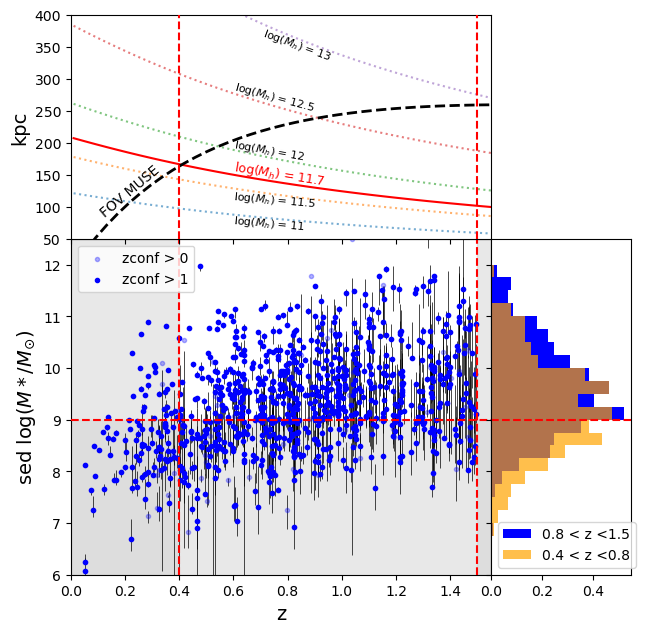

In [676]:
zz = np.linspace(0.01, 1.6, 40)
m11 = 10**(11)
m115 = 10**(11.5)
m117 = 10**(11.7)
m12 = 10**(12)
m125 = 10**(12.5)
m13 = 10**(13)
r11 = gt.get_Rvir(m11, zz)
r115 = gt.get_Rvir(m115, zz)
r117 = gt.get_Rvir(m117, zz)
r12 = gt.get_Rvir(m12, zz)
r125 = gt.get_Rvir(m125, zz)
r13 = gt.get_Rvir(m13, zz)

rr_fov = cosmo.kpc_proper_per_arcmin(zz)/2

Mmax = 12.5
Mmin = 6

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(7, 7), dpi = 100)
gs = fig.add_gridspec(5, 4, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
# Create the Axes.
ax = fig.add_subplot(gs[2:5, 0:3])
ax_fov = fig.add_subplot(gs[0:2, 0:3])
ax_histy = fig.add_subplot(gs[2:5, 3:4])


#---------------------------
#plt.title("Rvir vs Rfov", size = 20)
ax_fov.plot(zz, r11, alpha = 0.6, linestyle = "dotted")
ax_fov.plot(zz, r115, alpha = 0.6, linestyle = "dotted")
ax_fov.plot(zz, r117, label = "Rvir of logMh = 11.7", c = "r")
ax_fov.plot(zz, r12, alpha = 0.6, linestyle = "dotted")
ax_fov.plot(zz, r125, alpha = 0.6, linestyle = "dotted")
ax_fov.plot(zz, r13, alpha = 0.6, linestyle = "dotted")

ax_fov.text(0.6, 65, '$\log(M_h)$ = 11', fontsize = 8, color = 'black', rotation = -5);
ax_fov.text(0.6, 100, '$\log(M_h)$ = 11.5', fontsize = 8, color = 'black', rotation = -5);
ax_fov.text(0.6, 135, '$\log(M_h)$ = 11.7', fontsize = 9, color = 'red', rotation = -9);
ax_fov.text(0.6, 173, '$\log(M_h)$ = 12', fontsize = 8, color = 'black', rotation = -10);
ax_fov.text(0.6, 250, '$\log(M_h)$ = 12.5', fontsize = 8, color = 'black', rotation = -15);
ax_fov.text(0.7, 330, '$\log(M_h)$ = 13', fontsize = 8, color = 'black', rotation = -20);
ax_fov.text(0.1, 85, 'FOV MUSE', fontsize = 10, color = 'black', rotation = 40);


ax_fov.plot(zz, rr_fov, label = "Rfov", c = "black", linewidth = 2, linestyle = "--")
#ax_fov.legend()
#ax_fov.xlabel("z", size = 15)
#ax_fov.ylabel("kpc", size = 15)
ax_fov.set_xlim((0, 1.55))
ax_fov.set_xticklabels([])
ax_fov.axvline(0.4, c = 'r', linestyle = "--", zorder = 4)
ax_fov.axvline(1.5, c = 'r', linestyle = "--", zorder = 4)
ax_fov.set_ylabel("kpc", size = 14)
ax_fov.set_ylim((50, 400))
#-----------------------
ax.vlines(Rforeground_mass["Z"], Rforeground_mass["sed_logMass_l95"], Rforeground_mass["sed_logMass_u95"], \
          color = "black", linewidth = 0.5, zorder = 2)
ax.scatter(Rforeground_mass["Z"], Rforeground_mass["sed_logMass"],  marker='.', c = "blue", alpha = 0.3,\
                zorder = 3, label = "zconf > 0")
ax.scatter(Rforeground_zconf1_mass["Z"], Rforeground_zconf1_mass["sed_logMass"],  marker='.', c = "blue",\
           alpha = 1, zorder = 4, label = "zconf > 1")
ax.scatter(Rforeground_nomass["Z"], np.ones(len(Rforeground_nomass))*4.15,  marker='$\downarrow$', \
           c = "blue", alpha = 0.3, zorder = 3)
ax.scatter(Rforeground_zconf1_nomass["Z"], np.ones(len(Rforeground_zconf1_nomass))*4.15,  marker='$\downarrow$', \
           c = "blue", zorder = 3)
ax.set_ylim((Mmin, Mmax))
ax.set_xlim((0, 1.55))
ax.set_xlabel("z", size = 14)
ax.set_ylabel("sed $\log(M*/M_{\odot}$)", size = 14)
ax.legend()
# Créer un axe pour l'histogramme à droite du scatter plot
ax.axvline(0.4, c = 'r', linestyle = "--", zorder = 4)
ax.axvline(1.5, c = 'r', linestyle = "--", zorder = 4)
#ax.axvline(0.8, c = 'orange', linestyle = "--", zorder = 4)
ax.axhline(9, c = 'r', linestyle = "--", zorder = 4)
ax.axvspan(0, 0.4, color='lightgray', alpha=0.5, zorder = 1)
ax.axvspan(1.5, 2., color='lightgray', alpha=0.5, zorder = 1)
ax.axhspan(3, 9., color='lightgray', alpha=0.5,zorder = 1)

#-----------------------------

#plt.legend()
binsize = 0.25

nbins = int((Mmax - Mmin)/binsize)
ax_histy.hist(R_08_15_zconf1["sed_logMass"], bins = nbins, range = (Mmin,Mmax), \
             orientation='horizontal', color='blue', label = "0.8 < z <1.5", density = True);
ax_histy.hist(R_04_08_zconf1["sed_logMass"], bins = nbins,  range = (Mmin,Mmax),\
             orientation='horizontal', color='orange', label = "0.4 < z <0.8", alpha = 0.7, density = True);
#ax_histy.set_yticklabels([]);
ax_histy.axhline(9, c = 'r', linestyle = "--", zorder = 2)
ax_histy.set_ylim((Mmin, Mmax))
ax_histy.legend()
ax_histy.set_yticklabels([])

# Galaxy properties

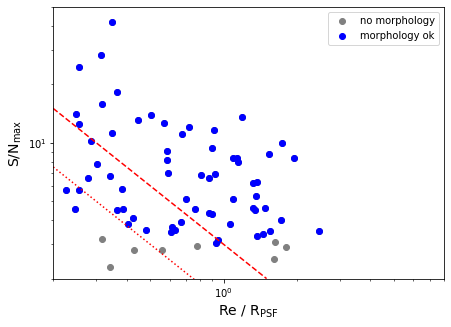

In [677]:
xx = np.linspace(0.2, 1.5, 100)
yy = 3/xx
yy1 = 1.5/xx
muse_sampling = 0.2
plt.figure(figsize = (7,5))
plt.scatter(isol_9["radius"]*muse_sampling/isol_9["psf_fwhm"], isol_9["snr_max"], c = "gray", \
            label = "no morphology")
#plt.scatter(isol_snr3["radius"]*muse_sampling/isol_snr3["psf_fwhm"], isol_snr3["snr_max"], c = "blue", \
#            label = "isolated S/N$_{\mathrm{eff}} > 3$")
plt.scatter(isol_visu["radius"]*muse_sampling/isol_visu["psf_fwhm"], isol_visu["snr_max"], c = "blue", \
            label = "morphology ok")
#plt.scatter(isol_snr3_good_runs["radius"]/isol_snr3_good_runs["psf_fwhm"], isol_snr3_good_runs["snr_max"], c = "blue")
#plt.scatter(isol_notgood_runs["radius"]*muse_sampling/isol_notgood_runs["psf_fwhm"], isol_notgood_runs["snr_max"], \
#            facecolors = "none", edgecolors = "red", s = 100, label = "bad runs")
plt.plot(xx, yy, c = "red", linestyle = "--")
#label = "S/N$_{\mathrm{eff}} = 3$"
plt.plot(xx, yy1, c = "red", linestyle = "dotted")
#label = "S/N$_{\mathrm{eff}} = 1.5$"
plt.xlabel("Re / R$_{\mathrm{PSF}}$", size = 14)
plt.ylabel("S/N$_{\mathrm{max}}$", size = 14)
#plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlim((0.2,8))
plt.ylim((2,50))


ax_fov.text(0.6, 65, '$\log(M_h)$ = 11', fontsize = 8, color = 'red', rotation = -5);

X = np.array(isol_visu_nok["radius"]*muse_sampling/isol_visu_nok["psf_fwhm"])
Y = np.array(isol_visu_nok["snr_max"])
txt = np.array(isol_visu_nok["ID"])

#for i in range(len(isol_visu_nok)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))
    

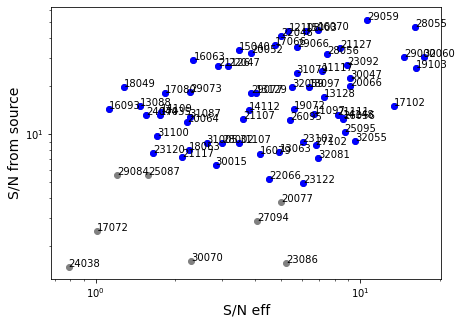

In [678]:
xx = np.linspace(0.2, 1.5, 100)
yy = 3/xx
yy1 = 1.5/xx
muse_sampling = 0.2
plt.figure(figsize = (7,5))
plt.scatter(isol_9["snr_eff"], isol_9["snr_from_src"], c = "gray",)
#plt.scatter(isol_lowM["snr_eff"], isol_lowM["snr_from_src"], c = "gray", marker = "x")
#plt.scatter(isol_snr3["snr_eff"], isol_snr3["snr_from_src"], c = "blue", \
#            label = "isolated S/N$_{\mathrm{eff}} > 3$")
plt.scatter(isol_visu["snr_eff"], isol_visu["snr_from_src"], c = "blue", \
            label = "visually ok for morpho")
#plt.scatter(isol_snr3_good_runs["radius"]/isol_snr3_good_runs["psf_fwhm"], isol_snr3_good_runs["snr_max"], c = "blue")
#plt.scatter(isol_notgood_runs["snr_eff"], isol_notgood_runs["snr_from_src"], \
#            facecolors = "none", edgecolors = "red", s = 100, label = "bad runs")
#plt.plot(xx, yy, c = "red", linestyle = "--", label = "S/N$_{\mathrm{eff}} = 3$")
#plt.plot(xx, yy1, c = "pink", linestyle = "--", label = "S/N$_{\mathrm{eff}} = 1.5$")
plt.xlabel("S/N eff", size = 14)
plt.ylabel("S/N from source", size = 14)
#plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.axhline()
#plt.legend()
#plt.xlim((0.2,8))
#plt.ylim((2,50))


X = np.array(isol_visu_nok["snr_eff"])
Y = np.array(isol_visu_nok["snr_from_src"])
txt = np.array(isol_visu_nok["ID"])

for i in range(len(isol_visu_nok)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))

X = np.array(isol_visu["snr_eff"])
Y = np.array(isol_visu["snr_from_src"])
txt = np.array(isol_visu["ID"])

for i in range(len(isol_visu)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))

(1, 100)

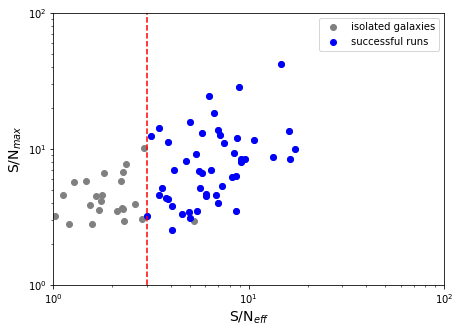

In [679]:
plt.figure(figsize = (7,5))
plt.scatter(isol_9["snr_eff"], isol_9["snr_max"], c = "gray", label = "isolated galaxies")
plt.scatter(isol_snr3_good_runs["snr_eff"], isol_snr3_good_runs["snr_max"], c = "blue", label = "successful runs")
plt.legend()
plt.xlabel("S/N$_{eff}$", size = 14)
plt.ylabel("S/N$_{max}$", size = 14)
plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlim((1,100))
plt.ylim((1,100))

Nb of isolated galaxies with morpho Ok 64


Text(0.5, 0, 'inclination')

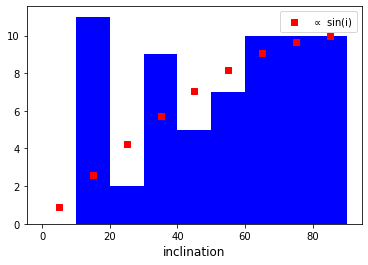

In [680]:
ii = np.linspace(5, 85, 9)
print("Nb of isolated galaxies with morpho Ok", len(isol_visu))
plt.hist(isol_visu["inclination"], bins = 9, range = (0,90), color = "blue");
plt.scatter(ii, np.sin(ii*2*np.pi/360)*10, c = "r", zorder = 3, marker = "s", label = "$\propto$ sin(i)")
plt.legend()
plt.xlabel("inclination", size = 12)

Nb of isolated galaxies with morpho Ok 64


Text(0.5, 0, '$\\alpha$')

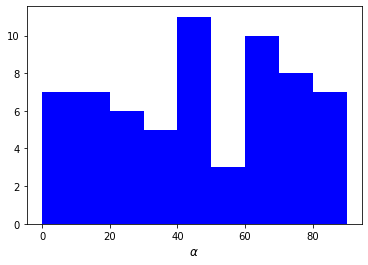

In [681]:
ii = np.linspace(5, 85, 9)
print("Nb of isolated galaxies with morpho Ok", len(isol_visu))
plt.hist(isol_visu["alpha"], bins = 9, range = (0,90), color = "blue");
#plt.scatter(ii, np.sin(ii*2*np.pi/360)*12, c = "r", zorder = 3, marker = "s", label = "$\propto$ sin(i)")
plt.xlabel("$\\alpha$", size = 12)

Nb of isolated galaxies with logM>9 : 72


Text(0, 0.5, 'log(SFR)')

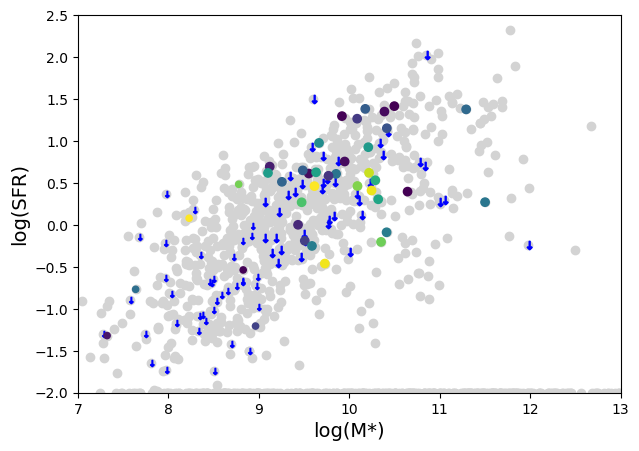

In [682]:
print("Nb of isolated galaxies with logM>9 :", len(isol_9))
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)
dv = 0.5e6

plt.scatter(R["sed_logMass"], R["logSFR"], c = 'lightgray')
plt.scatter(isol_9_abs["sed_logMass"], isol_9_abs["logSFR"], c = isol_9_abs["REW_2796"],\
                 zorder = 2)
            
plt.scatter(isol_9_noabs["sed_logMass"], isol_9_noabs["logSFR"], c = "blue",\
             marker = "$\downarrow$")

plt.scatter(isol_lowM_abs["sed_logMass"], isol_lowM_abs["logSFR"], c = isol_lowM_abs["REW_2796"],\
                 zorder = 2, s = 20)
            
plt.scatter(isol_lowM_noabs["sed_logMass"], isol_lowM_noabs["logSFR"], c = "blue",\
             marker = "$\downarrow$", s = 20)

plt.ylim((-2, 2.5))
plt.xlim((7, 13))
#plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("log(M*)", size = 14)
plt.ylabel("log(SFR)", size = 14)
#plt.legend()

# W-b

## whole sample

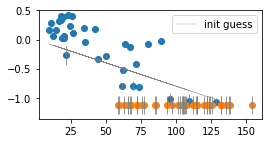

In [683]:
x1 = np.array(isol_9_abs["B_KPC"])
x2 = np.array(isol_9_noabs["B_KPC"])
y1 = np.array(np.log10(isol_9_abs["REW_2796"]))
y2 = np.array(np.log10(isol_9_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_9_abs["sig_REW_2796"]/isol_9_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

plt.figure(figsize = (4,2))
#plt.axhline(0, c = "red", linestyle = "--")
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.errorbar(x1, y1, yerr = sig_y1, c = "gray", linestyle = "none", linewidth = 0.8)
plt.errorbar(x2, y2, yerr = sig_y2, c = "gray", linestyle = "none", linewidth = 0.8)

#plt.plot(x0, A + B*x0, label = "true function", c = "black")

plt.plot(x1, 0.001 -0.008*x1, label = "init guess", c = "gray", linestyle = "--", linewidth = 0.4)
plt.legend()

In [684]:
fit_9 = minimize(gt.logL_stats_total, np.array([0.5,-0.01, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_9

      fun: 38.57478239837326
 hess_inv: array([[ 2.69622725e-02, -3.18308768e-04,  6.36611482e-04],
       [-3.18308768e-04,  4.94057881e-06, -9.88114306e-06],
       [ 6.36611482e-04, -9.88114306e-06,  1.97664771e-05]])
      jac: array([-1.43051147e-06, -4.67300415e-05,  1.43051147e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 132
      nit: 23
     njev: 33
   status: 2
  success: False
        x: array([ 0.54751862, -0.02068996,  0.47002685])

In [685]:
fit_9_1sig = np.diag(fit_9.hess_inv)**0.5
fit_9_1sig_inf = fit_9['x'] - fit_all_1sig
fit_9_1sig_sup = fit_9['x'] + fit_all_1sig

Nb of isolated galaxies with logM>9 : 72


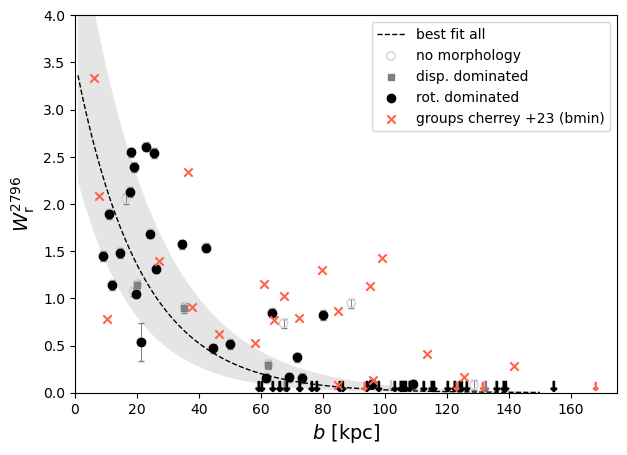

In [686]:
print("Nb of isolated galaxies with logM>9 :", len(isol_9))

X = np.linspace(1, 150, 200)

plt.figure(dpi = 100, figsize = (7, 5))

plt.plot(X, 10**gt.model(fit_9['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all")
plt.fill_between(X, 10**gt.model(fit_9_1sig_inf, X), 10**gt.model(fit_9_1sig_sup, X), \
                 color = "gray", alpha = 0.2, linewidth = 0)

plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], edgecolors = 'lightgray',\
                 zorder = 2, label = "no morphology", facecolors = "none")
plt.scatter(isol_visu_abs["B_KPC"], isol_visu_abs["REW_2796"], c = 'grey',\
                 zorder = 2, label = "disp. dominated", marker = "s", s = 25)
plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["REW_2796"], c = 'black',\
                 zorder = 2, label = "rot. dominated")
plt.errorbar(np.array(isol_9_abs["B_KPC"]), np.array(isol_9_abs["REW_2796"]), \
             yerr = np.maximum(isol_9_abs["sig_REW_2796"], 0.05),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = "x", c = "tomato", zorder = 3, \
           label = "groups cherrey +23 (bmin)")

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], edgecolors = "lightgray",\
             marker = "$\downarrow$", facecolors = "none", s = 50)
plt.scatter(isol_visu_noabs["B_KPC"], isol_visu_noabs["detection_limit_p75"], c = 'grey',\
                 zorder = 2, marker = "$\downarrow$", s = 50)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["detection_limit_p75"], c = 'black',\
                 zorder = 2, marker = "$\downarrow$", s = 50)
#plt.scatter(isol_incl_visu_rot_noabs["B_KPC"], isol_incl_visu_rot_noabs["detection_limit_p75"], c = 'lime',\
#                 zorder = 2, marker = "$\downarrow$")
plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["REW_2796"]+0.075, marker = "$\downarrow$", c = "tomato", zorder = 3)

plt.xlim((0, 175))
plt.ylim((0, 4))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$b$ [kpc]", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
plt.legend()

Nb of isolated galaxies with logM>9 : 72


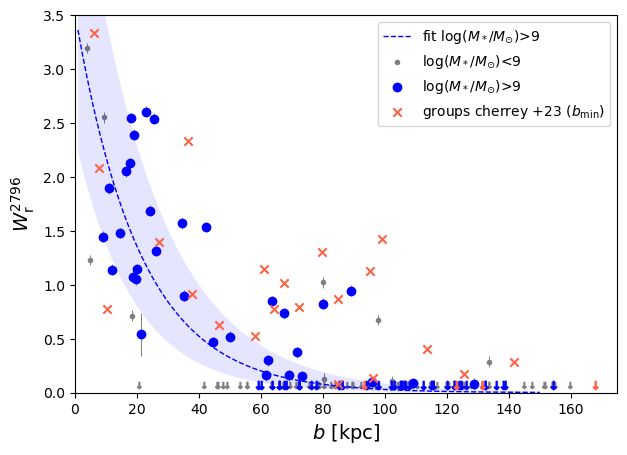

In [687]:
print("Nb of isolated galaxies with logM>9 :", len(isol_9))

X = np.linspace(1, 150, 200)

plt.figure(dpi = 100, figsize = (7, 5))


plt.scatter(isol_lowM_abs["B_KPC"], isol_lowM_abs["REW_2796"], marker = ".", c = "grey",\
           label = "$\log(M_*/M_{\odot})$<9")
plt.errorbar(np.array(isol_abs["B_KPC"]), np.array(isol_abs["REW_2796"]), \
             yerr = np.maximum(isol_abs["sig_REW_2796"], 0.05),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=0, zorder = 1)

plt.scatter(isol_lowM_noabs["B_KPC"], isol_lowM_noabs["detection_limit_p75"], c = "grey",\
            marker = "$\downarrow$", s = 20)

plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'blue',\
                 zorder = 2, label = "$\log(M_*/M_{\odot})$>9")
#plt.errorbar(np.array(isol_9_abs["B_KPC"]), np.array(isol_9_abs["REW_2796"]), \
#             yerr = np.maximum(isol_9_abs["sig_REW_2796"], 0.05),\
#            linestyle = "none", linewidth = 0.7, c = "grey", capsize=0, zorder = 1)
plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = "x", c = "tomato", zorder = 3, \
           label = "groups cherrey +23 ($b_{\mathrm{min}}$)")

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$")
#plt.scatter(isol_incl_visu_rot_noabs["B_KPC"], isol_incl_visu_rot_noabs["detection_limit_p75"], c = 'lime',\
#                 zorder = 2, marker = "$\downarrow$")
plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["REW_2796"]+0.075, marker = "$\downarrow$", c = "tomato", zorder = 3)
plt.fill_between(X, 10**gt.model(fit_9_1sig_inf, X), 10**gt.model(fit_9_1sig_sup, X), \
                 color = "blue", alpha = 0.1, linewidth = 0)
plt.plot(X, 10**gt.model(fit_9['x'], X), linewidth = 1.0, c = "blue", \
         linestyle = "--", label = "fit $\log(M_*/M_{\odot})$>9")


plt.xlim((0, 175))
plt.ylim((0.0, 3.5))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$b$ [kpc]", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
plt.legend()

# Influence of mass

In [688]:
x1 = np.array(isol_abs["B_KPC"])
x2 = np.array(isol_noabs["B_KPC"])
y1 = np.array(np.log10(isol_abs["REW_2796"]))
y2 = np.array(np.log10(isol_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_abs["sig_REW_2796"]/isol_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)


In [689]:
fit_all = minimize(gt.logL_stats_total, np.array([0.5,-0.01, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_all_1sig = np.diag(fit_all.hess_inv)**0.5
fit_all_1sig_inf = fit_all['x'] - fit_all_1sig
fit_all_1sig_sup = fit_all['x'] + fit_all_1sig
fit_all

      fun: 82.26039849210113
 hess_inv: array([[ 2.99391701e-02, -3.75917406e-04,  1.30548070e-03],
       [-3.75917406e-04,  7.39486309e-06, -1.21986971e-04],
       [ 1.30548070e-03, -1.21986971e-04,  8.76068642e-03]])
      jac: array([0.00000000e+00, 1.90734863e-06, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 132
      nit: 28
     njev: 33
   status: 0
  success: True
        x: array([ 0.29744969, -0.02259005,  0.7514116 ])

In [690]:
x1 = np.array(isol_lowM_abs["B_KPC"])
x2 = np.array(isol_lowM_noabs["B_KPC"])
y1 = np.array(np.log10(isol_lowM_abs["REW_2796"]))
y2 = np.array(np.log10(isol_lowM_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_lowM_abs["sig_REW_2796"]/isol_lowM_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

In [691]:
fit_lowM = minimize(gt.logL_stats_total, np.array([0.5,-0.01, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")

fit_lowM_1sig = np.diag(fit_lowM.hess_inv)**0.5
fit_lowM_1sig_inf = fit_lowM['x'] - fit_lowM_1sig
fit_lowM_1sig_sup = fit_lowM['x'] + fit_lowM_1sig
fit_lowM

      fun: 29.476847764524393
 hess_inv: array([[ 3.03481960e-01, -2.32149820e-03, -6.25921470e-02],
       [-2.32149820e-03,  5.68543152e-05, -1.52654675e-03],
       [-6.25921470e-02, -1.52654675e-03,  1.44766785e-01]])
      jac: array([ 4.76837158e-07, -4.29153442e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 160
      nit: 35
     njev: 40
   status: 0
  success: True
        x: array([-0.79666455, -0.0213003 ,  1.28502019])

Nb of isolated galaxies with logM>9 : 72


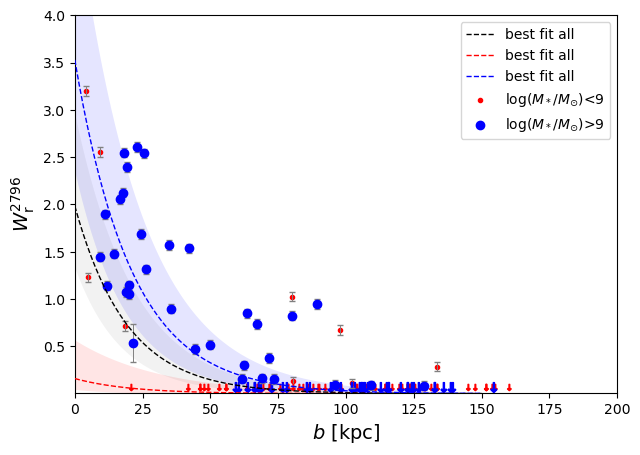

In [692]:
print("Nb of isolated galaxies with logM>9 :", len(isol_9))

X = np.linspace(0, 150, 200)

plt.figure(dpi = 100, figsize = (7, 5))

plt.plot(X, 10**gt.model(fit_all['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
plt.fill_between(X, 10**gt.model(fit_all_1sig_inf, X), 10**gt.model(fit_all_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)

plt.plot(X, 10**gt.model(fit_lowM['x'], X), linewidth = 1.0, c = "red", \
         linestyle = "--", label = "best fit all", zorder = 3)
plt.fill_between(X, 10**gt.model(fit_lowM_1sig_inf, X), 10**gt.model(fit_lowM_1sig_sup, X), \
                 color = "red", alpha = 0.1, linewidth = 0)

plt.plot(X, 10**gt.model(fit_9['x'], X), linewidth = 1.0, c = "blue", \
         linestyle = "--", label = "best fit all", zorder = 3)
plt.fill_between(X, 10**gt.model(fit_9_1sig_inf, X), 10**gt.model(fit_9_1sig_sup, X), \
                 color = "blue", alpha = 0.1, linewidth = 0)

plt.scatter(isol_lowM_abs["B_KPC"], isol_lowM_abs["REW_2796"], marker = ".", c = "red",\
           label = "$\log(M_*/M_{\odot})$<9")
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'blue',\
                 zorder = 2, label = "$\log(M_*/M_{\odot})$>9")
plt.errorbar(np.array(isol_abs["B_KPC"]), np.array(isol_abs["REW_2796"]), \
             yerr = np.maximum(isol_abs["sig_REW_2796"], 0.05),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)


plt.scatter(isol_lowM_noabs["B_KPC"], isol_lowM_noabs["detection_limit_p75"], c = "red",\
            marker = "$\downarrow$", s = 20)
plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$",  s = 50)

plt.xlim((0, 200))
plt.ylim((0.01, 4))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$b$ [kpc]", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
plt.legend()

# Influence of inclination and azimuth

In [693]:
x1 = np.array(isol_low_alpha_abs["B_KPC"])
x2 = np.array(isol_low_alpha_noabs["B_KPC"])
y1 = np.array(np.log10(isol_low_alpha_abs["REW_2796"]))
y2 = np.array(np.log10(isol_low_alpha_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_low_alpha_abs["sig_REW_2796"]/isol_low_alpha_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

In [694]:
fit_lowa = minimize(gt.logL_stats_total, np.array([0.5,-0.04, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_lowa_1sig = np.diag(fit_lowa.hess_inv)**0.5
fit_lowa_1sig_inf = fit_lowa['x'] - fit_lowa_1sig
fit_lowa_1sig_sup = fit_lowa['x'] + fit_lowa_1sig
fit_lowa

      fun: 1.7398519592131596
 hess_inv: array([[ 4.19429764e-02, -9.03370264e-04,  4.04001018e-03],
       [-9.03370264e-04,  2.64829603e-05, -2.16601207e-04],
       [ 4.04001018e-03, -2.16601207e-04,  8.57292390e-03]])
      jac: array([1.49011612e-07, 6.72042370e-06, 2.08616257e-07])
  message: 'Optimization terminated successfully.'
     nfev: 136
      nit: 26
     njev: 34
   status: 0
  success: True
        x: array([ 0.68670903, -0.02730642,  0.23862688])

In [695]:
x1 = np.array(isol_high_alpha_abs["B_KPC"])
x2 = np.array(isol_high_alpha_noabs["B_KPC"])
y1 = np.array(np.log10(isol_high_alpha_abs["REW_2796"]))
y2 = np.array(np.log10(isol_high_alpha_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_high_alpha_abs["sig_REW_2796"]/isol_high_alpha_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

In [696]:
fit_higha = minimize(gt.logL_stats_total, np.array([0.2,-0.01, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_higha_1sig = np.diag(fit_higha.hess_inv)**0.5
fit_higha_1sig_inf = fit_higha['x'] - fit_higha_1sig
fit_higha_1sig_sup = fit_higha['x'] + fit_higha_1sig
fit_higha

      fun: 7.368114413281624
 hess_inv: array([[ 1.80463829e-02, -2.47375750e-04,  7.64783186e-04],
       [-2.47375750e-04,  4.88113240e-06, -2.95692927e-05],
       [ 7.64783186e-04, -2.95692927e-05,  3.54611992e-03]])
      jac: array([-2.38418579e-07,  0.00000000e+00, -2.98023224e-07])
  message: 'Optimization terminated successfully.'
     nfev: 116
      nit: 24
     njev: 29
   status: 0
  success: True
        x: array([ 0.64614937, -0.01761839,  0.3053608 ])

In [697]:
x1 = np.array(isol_mid_alpha_abs["B_KPC"])
x2 = np.array(isol_mid_alpha_noabs["B_KPC"])
y1 = np.array(np.log10(isol_mid_alpha_abs["REW_2796"]))
y2 = np.array(np.log10(isol_mid_alpha_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_mid_alpha_abs["sig_REW_2796"]/isol_mid_alpha_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

In [698]:
fit_mida = minimize(gt.logL_stats_total, np.array([0.2,-0.01, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_mida_1sig = np.diag(fit_mida.hess_inv)**0.5
fit_mida_1sig_inf = fit_mida['x'] - fit_mida_1sig
fit_mida_1sig_sup = fit_mida['x'] + fit_mida_1sig
fit_mida

      fun: 3.2559193839874228
 hess_inv: array([[ 1.42264806e+00, -2.26171154e-02,  9.85725805e-02],
       [-2.26171154e-02,  3.91943473e-04, -2.56908098e-03],
       [ 9.85725805e-02, -2.56908098e-03,  8.98432780e-02]])
      jac: array([ 1.63912773e-06, -9.65595245e-06,  3.12924385e-06])
  message: 'Optimization terminated successfully.'
     nfev: 124
      nit: 27
     njev: 31
   status: 0
  success: True
        x: array([ 1.83277377, -0.04553205,  0.53967549])

In [699]:
x1 = np.array(isol_visu_low_incl_abs["B_KPC"])
x2 = np.array(isol_visu_low_incl_noabs["B_KPC"])
y1 = np.array(np.log10(isol_visu_low_incl_abs["REW_2796"]))
y2 = np.array(np.log10(isol_visu_low_incl_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_visu_low_incl_abs["sig_REW_2796"]/isol_visu_low_incl_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

In [700]:
fit_lowi = minimize(gt.logL_stats_total, np.array([0.2,-0.01, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_lowi_1sig = np.diag(fit_lowi.hess_inv)**0.5
fit_lowi_1sig_inf = fit_lowi['x'] - fit_lowi_1sig
fit_lowi_1sig_sup = fit_lowi['x'] + fit_lowi_1sig
fit_lowi

      fun: 2.5001246354824618
 hess_inv: array([[ 5.91861134e-02, -1.03641585e-03,  4.15127904e-03],
       [-1.03641585e-03,  2.85113306e-05, -3.76127532e-04],
       [ 4.15127904e-03, -3.76127532e-04,  2.04141147e-02]])
      jac: array([-4.67896461e-06, -8.19563866e-05, -1.37090683e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 224
      nit: 16
     njev: 53
   status: 2
  success: False
        x: array([ 0.42827768, -0.02514043,  0.26870562])

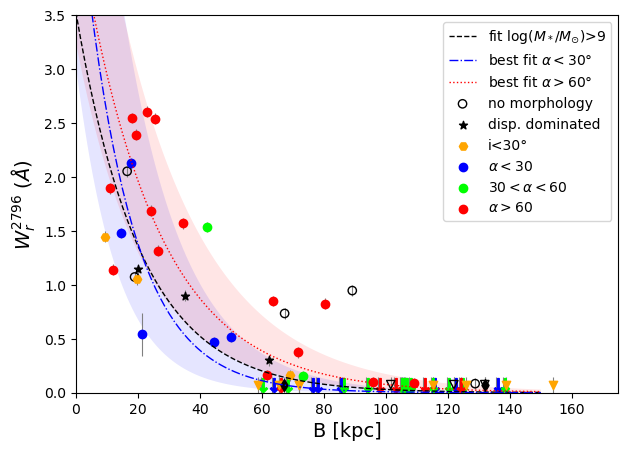

In [701]:
plt.figure(figsize = (7,5), dpi = 100)
X = np.linspace(0, 150, 200)

plt.plot(X, 10**gt.model(fit_9['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "fit $\log(M_*/M_{\odot})$>9")
#plt.fill_between(X, 10**gt.model(fit_9_1sig_inf, X), 10**gt.model(fit_9_1sig_sup, X), \
#                 color = "gray", alpha = 0.2, linewidth = 0)

plt.plot(X, 10**gt.model(fit_lowa['x'], X), linewidth = 1.0, c = "blue", \
         linestyle = "dashdot", label = "best fit $\\alpha<30°$")
plt.fill_between(X, 10**gt.model(fit_lowa_1sig_inf, X), 10**gt.model(fit_lowa_1sig_sup, X), \
                color = "blue", alpha = 0.1, linewidth = 0)

plt.plot(X, 10**gt.model(fit_higha['x'], X), linewidth = 1.0, c = "red", \
         linestyle = "dotted", label = "best fit $\\alpha>60°$")
plt.fill_between(X, 10**gt.model(fit_higha_1sig_inf, X), 10**gt.model(fit_higha_1sig_sup, X), \
                 color = "red", alpha = 0.1, linewidth = 0)

#plt.plot(X, 10**gt.model(fit_lowi['x'], X), linewidth = 1.0, c = "orange", \
#         linestyle = "dotted", label = "best fit $i<30°$")
#plt.fill_between(X, 10**gt.model(fit_lowi_1sig_inf, X), 10**gt.model(fit_lowi_1sig_sup, X), \
#                 color = "orange", alpha = 0.1, linewidth = 0)

#plt.plot(X, 10**gt.model(fit_mida['x'], X), linewidth = 1.0, c = "lime", \
#         linestyle = "dotted", label = "best fit $30°<\\alpha<60°$")
#plt.fill_between(X, 10**gt.model(fit_mida_1sig_inf, X), 10**gt.model(fit_mida_1sig_sup, X), \
#                 color = "lime", alpha = 0.1, linewidth = 0)

#-----------------------------------
#plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = "gray")
#plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], \
#            c = "gray", marker = "$\downarrow$", s = 100,)

plt.scatter(isol_visu_nok_abs["B_KPC"], isol_visu_nok_abs["REW_2796"], edgecolors = 'black',\
                 zorder = 2, label = "no morphology", facecolors = "none")
plt.scatter(isol_visu_disp_abs["B_KPC"], isol_visu_disp_abs["REW_2796"], c = 'black',\
                 zorder = 2, label = "disp. dominated", marker = "*")
plt.scatter(isol_visu_low_incl_abs["B_KPC"], isol_visu_low_incl_abs["REW_2796"], c = 'orange',\
                 zorder = 2, label = "i<30°", marker = "H")
plt.scatter(isol_visu_low_incl_noabs["B_KPC"], isol_visu_low_incl_noabs["detection_limit_p75"], c = 'orange',\
                 zorder = 2, marker = "v")
plt.scatter(isol_visu_nok_noabs["B_KPC"], isol_visu_nok_noabs["detection_limit_p75"], edgecolors = 'black',\
                 zorder = 2, facecolors = "none", marker = "v")
plt.scatter(isol_visu_disp_noabs["B_KPC"], isol_visu_disp_noabs["detection_limit_p75"], c = 'black',\
                 zorder = 2, marker = "d")
plt.errorbar(np.array(isol_9_abs["B_KPC"]), np.array(isol_9_abs["REW_2796"]),\
             yerr = np.maximum(isol_9_abs["sig_REW_2796"], 0.05), \
             c = "grey", linestyle = "none", linewidth = 0.8, zorder = 1)
plt.errorbar(np.array(isol_9_noabs["B_KPC"]), np.array(isol_9_noabs["detection_limit_p75"]),\
             yerr = np.maximum(isol_9_noabs["detection_limit_p75"], 0.05), \
             c = "grey", linestyle = "none", linewidth = 0.8, zorder = 1)


plt.scatter(isol_low_alpha_abs["B_KPC"], isol_low_alpha_abs["REW_2796"], c = "blue", zorder = 2, \
            label = "$\\alpha<30$")
plt.scatter(isol_low_alpha_noabs["B_KPC"], isol_low_alpha_noabs["detection_limit_p75"], \
            marker = "$\downarrow$", s = 100, c = "blue")

plt.scatter(isol_mid_alpha_abs["B_KPC"], isol_mid_alpha_abs["REW_2796"], c = "lime", zorder = 2,\
           label = "$30 < \\alpha<60$")
plt.scatter(isol_mid_alpha_noabs["B_KPC"], isol_mid_alpha_noabs["detection_limit_p75"], \
            marker = "$\downarrow$", s = 100, c = "lime")

plt.scatter(isol_high_alpha_abs["B_KPC"], isol_high_alpha_abs["REW_2796"], c = "red", zorder = 2,\
           label = "$\\alpha>60$")
plt.scatter(isol_high_alpha_noabs["B_KPC"], isol_high_alpha_noabs["detection_limit_p75"], \
            marker = "$\downarrow$", s = 100, c = "red")




plt.xlabel("B [kpc]", size = 14)
plt.ylabel("$W_r^{2796}$ ($\AA$)", size = 14)
plt.ylim((0.0, 3.5))
plt.xlim((0, 175))
plt.legend()
#plt.yscale("log")
#plt.xscale("log")

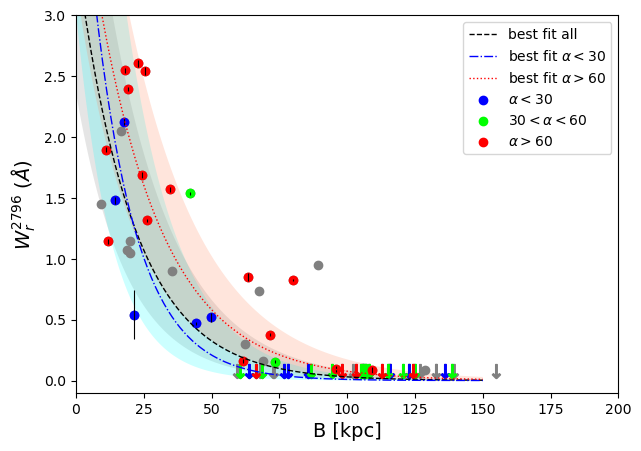

## 2D plots

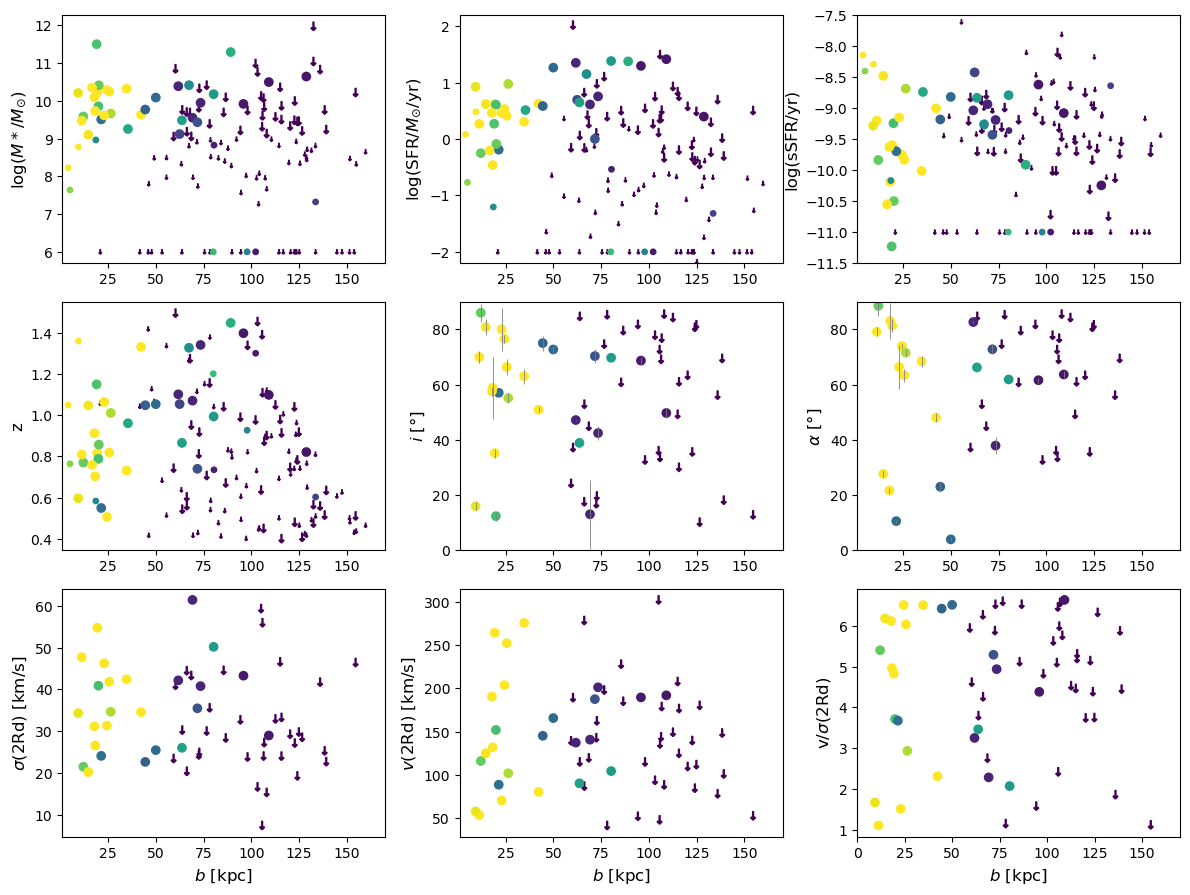

In [702]:
plt.figure(dpi = 100, figsize = (12, 9))

plt.subplot(331)
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["sed_logMass"], c = isol_9_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["sed_logMass"], c = isol_9_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.scatter(isol_lowM_abs["B_KPC"], isol_lowM_abs["sed_logMass"], c = isol_lowM_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5, marker = "o", s = 15)
plt.scatter(isol_lowM_noabs["B_KPC"], isol_lowM_noabs["sed_logMass"], c = isol_lowM_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5, s = 10)
plt.xlim((1, 170))
#plt.xlabel("b [kpc]", size = 14)
plt.ylabel("log($M*/M_{\odot}$)", size = 12)

plt.subplot(332)
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["logSFR"], c = isol_9_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["logSFR"], c = isol_9_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.scatter(isol_lowM_abs["B_KPC"], isol_lowM_abs["logSFR"], c = isol_lowM_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5, marker = "o", s = 15)
plt.scatter(isol_lowM_noabs["B_KPC"], isol_lowM_noabs["logSFR"], c = isol_lowM_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5, s = 10)
plt.xlim((1, 170))
plt.ylim((-2.2, 2.2))
#plt.xlabel("b [kpc]", size = 14)
plt.ylabel("log(SFR/$M_{\odot}$/yr)", size = 12)

plt.subplot(333)
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["logSSFR"], c = isol_9_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["logSSFR"], c = isol_9_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.scatter(isol_lowM_abs["B_KPC"], isol_lowM_abs["logSSFR"], c = isol_lowM_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5, marker = "o", s = 15)
plt.scatter(isol_lowM_noabs["B_KPC"], isol_lowM_noabs["logSSFR"], c = isol_lowM_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5, s = 10)
plt.xlim((1, 170))
plt.ylim((-11.5, -7.5))
#plt.xlabel("b [kpc]", size = 14)
plt.ylabel("log(sSFR/yr)", size = 12)

plt.subplot(334)
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["Z"], c = isol_9_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["Z"], c = isol_9_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.scatter(isol_lowM_abs["B_KPC"], isol_lowM_abs["Z"], c = isol_lowM_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5, marker = "o", s = 15)
plt.scatter(isol_lowM_noabs["B_KPC"], isol_lowM_noabs["Z"], c = isol_lowM_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5, s = 10)
plt.xlim((1, 170))
#plt.xlabel("b [kpc]", size = 14)
plt.ylabel("z", size = 12)

plt.subplot(335)
plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["inclination"], c = isol_visu_rot_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.errorbar(np.array(isol_visu_rot_abs["B_KPC"]), np.array(isol_visu_rot_abs["inclination"]), \
             yerr = np.array(isol_visu_rot_abs["inclination_err"]),\
                 linestyle = "none", color = "grey", linewidth = 0.6)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["inclination"], c = isol_visu_rot_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.xlim((1, 170))
plt.ylim((0,90))
#plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$i$ [°]", size = 12)

plt.subplot(336)
plt.scatter(isol_incl_visu_rot_abs["B_KPC"], isol_incl_visu_rot_abs["alpha"],\
            c = isol_incl_visu_rot_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.errorbar(np.array(isol_incl_visu_rot_abs["B_KPC"]), np.array(isol_incl_visu_rot_abs["alpha"]), \
             yerr = np.array(isol_incl_visu_rot_abs["pa_err"]),\
                 linestyle = "none", color = "grey", linewidth = 0.6)
plt.scatter(isol_incl_visu_rot_noabs["B_KPC"], isol_incl_visu_rot_noabs["inclination"], \
            c = isol_incl_visu_rot_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.xlim((1, 170))
plt.ylim((0,90))
#plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$\\alpha$ [°]", size = 12)

plt.subplot(337)
plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["velocity_dispersion_2Rd"], \
            c = isol_visu_rot_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["velocity_dispersion_2Rd"], \
            c = isol_visu_rot_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.xlim((1, 170))
plt.xlabel("$b$ [kpc]", size = 12)
plt.ylabel("$\sigma$(2Rd) [km/s]", size = 12)

plt.subplot(338)
plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["v22"], c = isol_visu_rot_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["v22"], c = isol_visu_rot_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.xlim((1, 170))
plt.xlabel("$b$ [kpc]", size = 12)
plt.ylabel("$v$(2Rd) [km/s]", size = 12)

plt.subplot(339)
plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["v22"]/isol_visu_rot_abs["velocity_dispersion_2Rd"],\
            c = isol_visu_rot_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["v22"]/isol_visu_rot_noabs["velocity_dispersion_2Rd"],\
            c = isol_visu_rot_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.xlim((0, 170))
plt.xlabel("$b$ [kpc]", size = 12)
plt.ylabel("v/$\sigma$(2Rd)", size = 12)
plt.tight_layout()

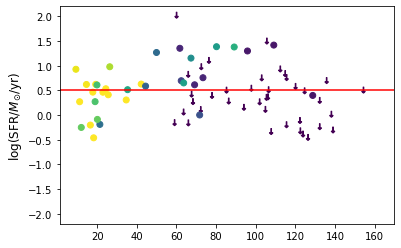

In [706]:
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["logSFR"], c = isol_9_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["logSFR"], c = isol_9_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
#plt.scatter(isol_lowM_abs["B_KPC"], isol_lowM_abs["logSFR"], c = isol_lowM_abs["REW_2796"],\
#                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5, marker = "o", s = 15)
#plt.scatter(isol_lowM_noabs["B_KPC"], isol_lowM_noabs["logSFR"], c = isol_lowM_noabs["REW_2796"],\
#             marker = "$\downarrow$", vmin = 0, vmax = 1.5, s = 10)
plt.xlim((1, 170))
plt.ylim((-2.2, 2.2))
#plt.xlabel("b [kpc]", size = 14)
plt.ylabel("log(SFR/$M_{\odot}$/yr)", size = 12)
plt.axhline(0.5, c = "r")

### multiple parameters fit

In [775]:
x1 = np.array([isol_abs["B_KPC"], isol_abs["Z"], isol_abs["logSSFR"], isol_abs["sed_logMass"]])
x2 = np.array([isol_noabs["B_KPC"], isol_noabs["Z"], isol_noabs["logSSFR"], isol_noabs["sed_logMass"]])
y1 = np.array(np.log10(isol_abs["REW_2796"]))
y2 = np.array(np.log10(isol_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_abs["sig_REW_2796"]/isol_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(x2.shape[1])*0.15)

In [776]:
fit_multi = minimize(gt.logL_stats_total_multi, np.array([0.2,-0.01, 0.1, 0.01, 0.01, 0.01]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_multi_1sig = np.diag(fit_lowi.hess_inv)**0.5
fit_multi_1sig_inf = fit_lowi['x'] - fit_lowi_1sig
fit_multi_1sig_sup = fit_lowi['x'] + fit_lowi_1sig
fit_multi

      fun: 75.58108782235227
 hess_inv: array([[ 8.82296686e-01, -2.58562430e-04, -1.22998154e-01,
         4.17407469e-02, -3.68648828e-02, -1.33713557e-02],
       [-2.58562430e-04,  6.42401647e-06, -7.08746593e-05,
         2.08815414e-06,  1.32727909e-06, -9.25107817e-05],
       [-1.22998154e-01, -7.08746593e-05,  9.18043075e-02,
        -2.79579052e-03,  1.31497502e-03,  4.90180259e-03],
       [ 4.17407469e-02,  2.08815414e-06, -2.79579052e-03,
         3.64254808e-03, -4.92105010e-04,  8.77257747e-05],
       [-3.68648828e-02,  1.32727909e-06,  1.31497502e-03,
        -4.92105010e-04,  3.28987716e-03,  1.10512500e-03],
       [-1.33713557e-02, -9.25107817e-05,  4.90180259e-03,
         8.77257747e-05,  1.10512500e-03,  7.27022113e-03]])
      jac: array([ 0.00000000e+00, -9.53674316e-07,  9.53674316e-07,  1.90734863e-06,
       -1.90734863e-06,  9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 623
      nit: 76
     njev: 89
   status: 0
  success:

In [777]:
gt.model_multi(fit_multi['x'], X).shape

(200,)

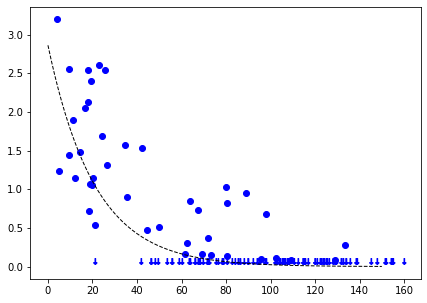

In [778]:
plt.figure(figsize = (7,5))
B_arr = np.linspace(0, 150, 200)
z_arr = np.linspace(1, 1, 200)
sfr_arr = np.linspace(0, 0, 200)
m_arr = np.linspace(9, 9, 200)
X = np.array([B_arr, z_arr, sfr_arr, m_arr])
plt.plot(B_arr, 10**gt.model_multi(fit_multi['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "fit $\log(M_*/M_{\odot})$>9")
plt.scatter(isol_abs["B_KPC"], isol_abs["REW_2796"], c = 'blue',\
                 zorder = 2, label = "$\log(M_*/M_{\odot})$>9")
plt.scatter(isol_noabs["B_KPC"], isol_noabs["detection_limit_p75"], c = 'blue',\
                 zorder = 2, marker = "$\downarrow$")

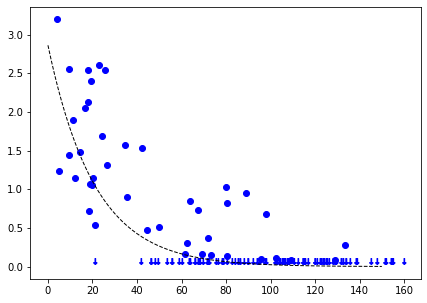

In [779]:
plt.figure(figsize = (7,5))
B_arr = np.linspace(0, 150, 200)
z_arr = np.linspace(1, 1, 200)
sfr_arr = np.linspace(0, 0, 200)
m_arr = np.linspace(9, 9, 200)
X = np.array([B_arr, z_arr, sfr_arr, m_arr])
plt.plot(B_arr, 10**gt.model_multi(fit_multi['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "fit $\log(M_*/M_{\odot})$>9")
plt.scatter(isol_abs["B_KPC"], isol_abs["REW_2796"], c = 'blue',\
                 zorder = 2, label = "$\log(M_*/M_{\odot})$>9")
plt.scatter(isol_noabs["B_KPC"], isol_noabs["detection_limit_p75"], c = 'blue',\
                 zorder = 2, marker = "$\downarrow$")

Text(0, 0.5, 'Z')

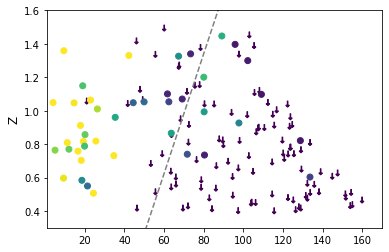

In [780]:
# cst, b, z, sfr, m
bb = np.linspace(0, 100, 100)
z_predict01 = gt.predict_z(fit_multi['x'], bb, sfr = 0, logm = 9, rew = 0.1)
z_predict05 = gt.predict_z(fit_multi['x'], bb, sfr = 0, logm = 9, rew = 0.5)
z_predict1 = gt.predict_z(fit_multi['x'], bb, sfr = 0, logm = 9, rew = 1.0)
plt.scatter(isol_abs["B_KPC"], isol_abs["Z"], c = isol_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_noabs["B_KPC"], isol_noabs["Z"], c = isol_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.plot(bb, z_predict01, c = 'grey', linestyle = "--")
#plt.plot(bb, z_predict05, c = 'grey', linestyle = "--")
#plt.plot(bb, z_predict1, c = 'grey', linestyle = "--")
#plt.scatter(isol_lowM_abs["B_KPC"], isol_lowM_abs["logSFR"], c = isol_lowM_abs["REW_2796"],\
#                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5, marker = "o", s = 15)
#plt.scatter(isol_lowM_noabs["B_KPC"], isol_lowM_noabs["logSFR"], c = isol_lowM_noabs["REW_2796"],\
#             marker = "$\downarrow$", vmin = 0, vmax = 1.5, s = 10)
plt.xlim((1, 170))
plt.ylim((0.3, 1.6))
#plt.xlabel("b [kpc]", size = 14)
plt.ylabel("Z", size = 12)
#plt.axhline(0.5, c = "r")

Text(0, 0.5, 'log(SFR/$M_{\\odot}$/yr)')

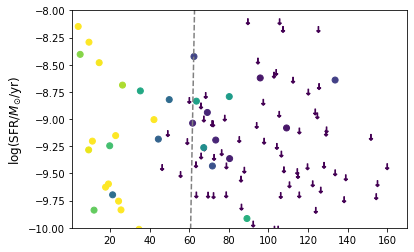

In [784]:
# cst, b, z, sfr, m
bb = np.linspace(0, 100, 100)
z_predict01 = gt.predict_sfr(fit_multi['x'], bb, z = 1, logm = 9, rew = 0.1)
z_predict05 = gt.predict_sfr(fit_multi['x'], bb, z = 1, logm = 9, rew = 0.5)
z_predict1 = gt.predict_sfr(fit_multi['x'], bb, z = 1, logm = 9, rew = 1.0)
plt.scatter(isol_abs["B_KPC"], isol_abs["logSSFR"], c = isol_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_noabs["B_KPC"], isol_noabs["logSSFR"], c = isol_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.plot(bb, z_predict01, c = 'grey', linestyle = "--")
#plt.plot(bb, z_predict05, c = 'grey', linestyle = "--")
#plt.plot(bb, z_predict1, c = 'grey', linestyle = "--")
#plt.scatter(isol_lowM_abs["B_KPC"], isol_lowM_abs["logSFR"], c = isol_lowM_abs["REW_2796"],\
#                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5, marker = "o", s = 15)
#plt.scatter(isol_lowM_noabs["B_KPC"], isol_lowM_noabs["logSFR"], c = isol_lowM_noabs["REW_2796"],\
#             marker = "$\downarrow$", vmin = 0, vmax = 1.5, s = 10)
plt.xlim((1, 170))
plt.ylim((-10, -8))
#plt.xlabel("b [kpc]", size = 14)
plt.ylabel("log(SFR/$M_{\odot}$/yr)", size = 12)
#plt.axvline(60, c = "r")

Text(0, 0.5, 'log(SFR/$M_{\\odot}$/yr)')

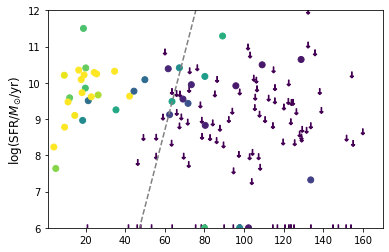

In [774]:
# cst, b, z, sfr, m
bb = np.linspace(0, 100, 100)
z_predict01 = gt.predict_logm(fit_multi['x'], bb, z = 1, sfr = 0, rew = 0.1)
z_predict05 = gt.predict_logm(fit_multi['x'], bb, z = 1, sfr = 0, rew = 0.5)
z_predict1 = gt.predict_logm(fit_multi['x'], bb, z = 1, sfr = 0, rew = 1.0)
plt.scatter(isol_abs["B_KPC"], isol_abs["sed_logMass"], c = isol_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_noabs["B_KPC"], isol_noabs["sed_logMass"], c = isol_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.plot(bb, z_predict01, c = 'grey', linestyle = "--")
#plt.plot(bb, z_predict05, c = 'grey', linestyle = "--")
#plt.plot(bb, z_predict1, c = 'grey', linestyle = "--")
#plt.scatter(isol_lowM_abs["B_KPC"], isol_lowM_abs["logSFR"], c = isol_lowM_abs["REW_2796"],\
#                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5, marker = "o", s = 15)
#plt.scatter(isol_lowM_noabs["B_KPC"], isol_lowM_noabs["logSFR"], c = isol_lowM_noabs["REW_2796"],\
#             marker = "$\downarrow$", vmin = 0, vmax = 1.5, s = 10)
plt.xlim((1, 170))
plt.ylim((6, 12))
#plt.xlabel("b [kpc]", size = 14)
plt.ylabel("log(SFR/$M_{\odot}$/yr)", size = 12)
#plt.axhline(0.5, c = "r")

# Disk halo decomposition

In [503]:
R = pd.read_csv("results_decomp_3.csv")

#bad_runs_ids = [11083, 12121, 23086, 23120, 26056, 26092, 29002, 29084, 28102, 30070, 30093, 31005]
low_cstr = [14120]
no_morpho = [11083, 12103, 20077, 21117, 23086, 24038, 25087, 27094, 29073, 30070]

no_morpho_isol = [11083, 12103, 20077, 23086, 24038, 27094, 30070]

to_remove = [11083, 24052]

R['sed_logMass'] = R['sed_logMass'].fillna(6)
R.loc[R['sed_logMass'] < 1, 'sed_logMass'] = 6 # because we have some galaxy with sed_logMass = -21
R["logSFR"] = np.log10(R["SFR_gilbank"])
R["logSSFR"] = np.log10(R["SFR_gilbank"]/R["sed_logMass"])
R['logSFR'] = R['logSFR'].fillna(-2)
R['logSSFR'] = R['logSSFR'].fillna(-5)

R["orientation"] = 1 #an alternative method is to use a flag. 0 = accretion, 1 = middle, 2 = wind.
R.loc[R["alpha"] < 30, "orientation"] = 0
R.loc[R["alpha"] > 60, "orientation"] = 2

In [504]:
R = gt.isolated_auto_modif3(R, Mh = 10**(11.7), b_sep = 0, dv = 0.5e6, group_threshold = 4, logm_sat = 0)
R = gt.get_closest(R, dv = 0.5e6, group_threshold = 4, logm_sat = 0, ZCONF_lim = 0)

In [505]:
R.loc[R["ID"] == 14113, "bool_absorption"] = 0
R.loc[R["ID"] == 14113, "REW_2796"] = 0

In [506]:
f100 = R["B_KPC"] <= 100
f150 = R["B_KPC"] <= 150
f200 = R["B_KPC"] <= 200
fsnr3 = R["snr_eff"]>=3
fincl30 = R["inclination"] >= 30 
fabs = R["bool_absorption"] == 1
fqso = R["is_QSO"] == 0
fclosest = R["is_closest"] == 1
fzlow = R["Z"] > 0.4
fzlow_08 = R["Z"] > 0.8
fzhigh = R["Z"] < 1.5
fzhigh_1 = R["Z"] < 1
fzhigh_09 = R["Z"] < 0.9
fzhigh_08 = R["Z"] < 0.8
fzconf_0 = R["ZCONF"] > 0
fzconf_1 = R["ZCONF"] > 1
fstar = R["is_star"] == 0
flowa = R["alpha"] <= 30
fmida = (R["alpha"] >= 30) & (R["alpha"] <= 60)
fhigha = R["alpha"] >= 60
fisol = R["isolated_auto"] == 1
fm9 = R["sed_logMass"] >= 9
fconv = R["run_convergence_global"] >= 0.99
fbad = R["ID"].isin(bad_runs_ids)
fno_morpho = R["ID"].isin(no_morpho)
fnomass = R["sed_logMass"].isna()
f_SFR1 = np.log10(R["SFR_gilbank"]) >= 0
f_SFR01 = np.log10(R["SFR_gilbank"]) >= 0
fbehind = R["Z"]<(R["zqso_sdss"] - 1e6*(R["zqso_sdss"]+1)/const.c.value)
fnomass = R["sed_logMass"] == 6
frot = (R["v22"]+0.01)/R["velocity_dispersion_2Rd"] > 1
fremove = R["ID"].isin(to_remove)

In [507]:
Rforeground = R[fqso & fstar & fbehind & fzconf_0]
Rforeground_zconf1 = R[fqso & fstar & fbehind & fzconf_1]
Rforeground_mass = R[fqso & fstar & fbehind & fzconf_0 & ~fnomass]
Rforeground_zconf1_mass = R[fqso & fstar & fbehind & fzconf_1 & ~fnomass]
Rforeground_nomass = R[fqso & fstar & fbehind & fzconf_0 & fnomass]
Rforeground_zconf1_nomass = R[fqso & fstar & fbehind & fzconf_0 & fnomass]

R_04_15 = R[fzlow & fzhigh & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_15_zconf1 = R[fzlow & fzhigh & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_08_15_zconf1 = R[fzlow_08 & fzhigh & fqso & fstar & fbehind & fzconf_1 & ~fnomass]

R_04_1 = R[fzlow & fzhigh_1 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_1_zconf1 = R[fzlow & fzhigh_1 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_09 = R[fzlow & fzhigh_09 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_09_zconf1 = R[fzlow & fzhigh_09 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_08 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_08_zconf1 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_08_zconf1 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]

R_9 = R[fqso & fstar & f100 & fzlow & fzhigh & fzconf_1 & fbehind & fm9]
R100 = R[fqso & fstar & fzlow & fzhigh & fbehind & f100] 
R150 = R[fqso & fstar & fzlow & fzhigh & fbehind & f150]
R150_snr3 = R[fqso & fstar & fzlow & fzhigh & f150 & fconv & fsnr3 & ~fbad & fzconf_1]
R200 = R[fqso & fstar & fzlow & fzhigh & fbehind & f200]

isol = R[fqso & fstar & fisol & fbehind & ~fremove] #isolated galaxies
isol_abs = R[fqso & fstar & fisol & fabs & fbehind & ~fremove]
isol_noabs = R[fqso & fstar & fisol & ~fabs & fbehind & ~fremove]
isol_zconf = R[fqso & fstar & fisol & fzconf_1 & fbehind & ~fremove]
isol_zconf_abs = R[fqso & fstar & fisol & fzconf_1 & fabs & fbehind & ~fremove]
isol_zconf_noabs = R[fqso & fstar & fisol & fzconf_1 & ~fabs & fbehind & ~fremove]
isol_zselec = R[fqso & fstar & fisol & fzlow & fzhigh & fbehind & ~fremove] # isolated in z= 0.4 - 1.5
isol_zselec_mass = R[fqso & fstar & fisol & fzconf_1 & fzlow & fzhigh & fbehind & ~fnomass & ~fremove] 
isol_zselec_nomass = R[fqso & fstar & fisol & fzconf_1 & fzlow & fzhigh & fbehind & fnomass & ~fremove]
isol_zconf_1 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1
isol_9 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fabs & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & ~fabs & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_lowM = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* below 1e9
isol_lowM_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fabs & fbehind & ~fremove]
isol_lowM_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & ~fabs & fbehind & ~fremove]
isol_9_convergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fbehind & ~fremove] # idem with good convergence
isol_9_noconvergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & ~fconv & fbehind & ~fremove] # idem with good convergence
isol_lowM_convergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fconv & fbehind & ~fremove]
isol_snr3 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbehind & ~fremove] # idem with good snr
isol_snr3_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbehind & fabs & ~fremove] # idem with good snr
isol_snr3_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbehind & ~fabs & ~fremove] # idem with good snr


isol_lowM_snr3 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fconv & fsnr3 & fbehind]
isol_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fbad & fbehind] # good runs
isol_notgood_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fbad & fbehind]
isol_snr3_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind] # good runs
isol_snr3_notgood_runs = R[fqso & fstar& fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbad & fbehind]
isol_snr3_good_runs_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fabs & fbehind] # good runs
isol_snr3_good_runs_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & ~fabs & fbehind] # good runs
isol_snr3_good_runs_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot] # good runs
isol_snr3_good_runs_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot & fabs] # good runs
isol_snr3_good_runs_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot & ~fabs] # good runs

isol_incl_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & frot] # good runs
isol_incl_good_runs_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fabs & fbehind & frot] # good runs
isol_incl_good_runs_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & ~fabs & fbehind & frot] # good runs


isol_high_alpha = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & frot & ~fremove]
isol_high_alpha_abs = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & frot & ~fremove]
isol_high_alpha_noabs = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & frot & ~fremove]
isol_mid_alpha = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & frot & ~fremove]
isol_mid_alpha_abs = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & frot & ~fremove]
isol_mid_alpha_noabs = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & frot & ~fremove]
isol_low_alpha = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & frot & ~fremove]
isol_low_alpha_abs = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & frot & ~fremove]
isol_low_alpha_noabs = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & frot & ~fremove]


#---- from visual inspection----
isol_behroozi = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho]
isol_visu = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fremove]
isol_visu_nok = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & (fno_morpho | fremove)]
isol_visu_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fabs & ~fremove]
isol_visu_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fabs & ~fremove]
isol_visu_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & ~fremove]
isol_visu_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & fabs & ~fremove]
isol_visu_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & ~fabs & ~fremove]
isol_incl_visu_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & ~fremove]
isol_incl_visu_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & fabs & frot & ~fremove]
isol_incl_visu_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & ~fabs & frot & ~fremove]

isol_visu_low_incl = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fincl30 & frot & ~fremove]
isol_visu_high_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fhigha & ~fremove]
isol_visu_low_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & flowa & ~fremove]


#----


closest = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fremove]
closest_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & ~fremove]
closest_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & ~fremove]
closest_9 = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & ~fremove]
closest_9_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9 & ~fremove]
closest_9_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9 & ~fremove]
closest_9_snr3 = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fremove]
closest_9_snr3_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & fabs & ~fremove]
closest_9_snr3_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fabs & ~fremove]
closest_9_snr3_good_runs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fbad & ~fremove & ~fremove]
closest_9_snr3_good_runs_rot = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot & ~fremove] # good runs
closest_9_snr3_good_runs_rot_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot & fabs & ~fremove] # good runs
closest_9_snr3_good_runs_rot_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot & ~fabs & ~fremove] # good runs
closest_9_snr3_good_runs_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9 & fsnr3 & ~fbad & ~fremove]
closest_9_snr3_good_runs_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9 & fsnr3 & ~fbad & ~fremove]



closest_incl = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fbad & fincl30 & ~fremove]
closest_incl_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9 & fsnr3 & ~fbad & fincl30 & ~fremove]
closest_incl_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9 & fsnr3 & ~fbad & fincl30 & ~fremove]

closest_high_alpha = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fremove]
closest_high_alpha_abs = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & ~fremove]
closest_high_alpha_noabs = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & ~fremove]
closest_mid_alpha = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fremove]
closest_mid_alpha_abs = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & ~fremove]
closest_mid_alpha_noabs = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & ~fremove]
closest_low_alpha = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fremove]
closest_low_alpha_abs = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & ~fremove]
closest_low_alpha_noabs = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & ~fremove]



print("Number of galaxies with logM > 9, good z, QSO behind, good zconf = ", len(R_9))
print("Number of isolated = ", len(isol))
print("Number of isolated with abs = ", len(isol_abs))
print("Number of distinct absorptions associated with isolated  = ", len(isol_abs["abs_id"].unique()))
print("Number of isolated with zconf >= 2 ", len(isol_zconf))
print("Number of isolated at 0.4 < z < 1.5 = ", len(isol_zselec))
print("Number of isolated at 0.4 < z < 1.5 and zconf >= 2 ", len(isol_zconf_1))
print("and with mass = ", len(isol_zselec_mass))
print("or without mass = ", len(isol_zselec_nomass))
print("with the previous filters on isolation, z, zconf and QSO behind:")
print("Number of isolated with logM > 9 = ", len(isol_9))
print("Number of isolated with logM > 9 and multinest run = ", len(isol_9[isol_9["run_name"] == "run_OII_multinest"]))
print("Number of isolated with logM > 9 with abs = ", len(isol_9_abs))
print("Number of isolated with logM > 9 without abs = ", len(isol_9_noabs))
print("Number of isolated with logM > 9 and good convergence = ", len(isol_9_convergence))
print("Number of isolated with logM > 9 and snr_eff > 3  = ", len(isol_snr3))
print("Number of isolated with logM > 9 and good galpak runs  = ", len(isol_good_runs))
print("Number of isolated with logM > 9 and good runs and snr_eff > 3  = ", len(isol_snr3_good_runs))
print("Number of isolated with logM > 9 and good galpak runs, rot dominated  = ", len(isol_snr3_good_runs_rot))
print("Number of isolated with logM > 9 and good galpak runs, rot dominated with abs = ", len(isol_snr3_good_runs_rot_abs))
print("Number of isolated with logM > 9 and good galpak runs, rot dominated without abs= ", len(isol_snr3_good_runs_rot_noabs))
print("Number of isolated with logM > 9 and good galpak runs and incl>30 = ", len(isol_incl_good_runs))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 ", len(closest))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9", len(closest_9))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9 and abs", len(closest_9_abs))
print("")
print("** FOR THE PAPER: **")
print("** Volume limited sample (A)**")
print("Nb of galaxies in 0.4 - 1.5:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_0]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 :", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 log(M) > 9:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 log(M) > 9 and foreground:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind]))
print("** Isolated galaxies **")
print(" (A) and isolated:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind & fisol]))
print("** closest galaxies **")
print(" (A) and closest:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind & fclosest]))

Number of galaxies with logM > 9, good z, QSO behind, good zconf =  127
Number of isolated =  257
Number of isolated with abs =  43
Number of distinct absorptions associated with isolated  =  43
Number of isolated with zconf >= 2  205
Number of isolated at 0.4 < z < 1.5 =  176
Number of isolated at 0.4 < z < 1.5 and zconf >= 2  144
and with mass =  116
or without mass =  28
with the previous filters on isolation, z, zconf and QSO behind:
Number of isolated with logM > 9 =  72
Number of isolated with logM > 9 and multinest run =  0
Number of isolated with logM > 9 with abs =  33
Number of isolated with logM > 9 without abs =  39
Number of isolated with logM > 9 and good convergence =  72
Number of isolated with logM > 9 and snr_eff > 3  =  51
Number of isolated with logM > 9 and good galpak runs  =  71
Number of isolated with logM > 9 and good runs and snr_eff > 3  =  50
Number of isolated with logM > 9 and good galpak runs, rot dominated  =  43
Number of isolated with logM > 9 and good

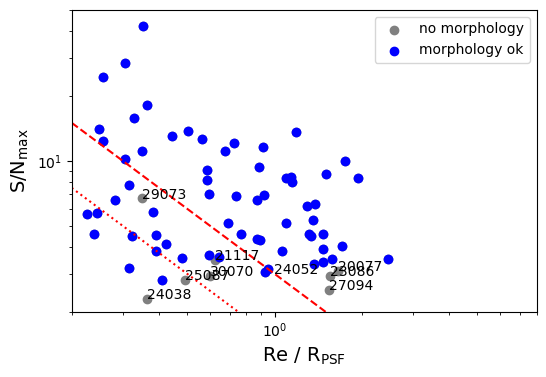

In [508]:
xx = np.linspace(0.2, 1.5, 100)
yy = 3/xx
yy1 = 1.5/xx
muse_sampling = 0.2
plt.figure(dpi = 100)
plt.scatter(isol_9["radius"]*muse_sampling/isol_9["psf_fwhm"], isol_9["snr_max"], c = "gray", \
            label = "no morphology")
#plt.scatter(isol_snr3["radius"]*muse_sampling/isol_snr3["psf_fwhm"], isol_snr3["snr_max"], c = "blue", \
#            label = "isolated S/N$_{\mathrm{eff}} > 3$")
plt.scatter(isol_visu["radius"]*muse_sampling/isol_visu["psf_fwhm"], isol_visu["snr_max"], c = "blue", \
            label = "morphology ok")
#plt.scatter(isol_snr3_good_runs["radius"]/isol_snr3_good_runs["psf_fwhm"], isol_snr3_good_runs["snr_max"], c = "blue")
#plt.scatter(isol_notgood_runs["radius"]*muse_sampling/isol_notgood_runs["psf_fwhm"], isol_notgood_runs["snr_max"], \
#            facecolors = "none", edgecolors = "red", s = 100, label = "bad runs")
plt.plot(xx, yy, c = "red", linestyle = "--")
#label = "S/N$_{\mathrm{eff}} = 3$"
plt.plot(xx, yy1, c = "red", linestyle = "dotted")
#label = "S/N$_{\mathrm{eff}} = 1.5$"
plt.xlabel("Re / R$_{\mathrm{PSF}}$", size = 14)
plt.ylabel("S/N$_{\mathrm{max}}$", size = 14)
#plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlim((0.2,8))
plt.ylim((2,50))


X = np.array(isol_visu_nok["radius"]*muse_sampling/isol_visu_nok["psf_fwhm"])
Y = np.array(isol_visu_nok["snr_max"])
txt = np.array(isol_visu_nok["ID"])

for i in range(len(isol_visu_nok)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))

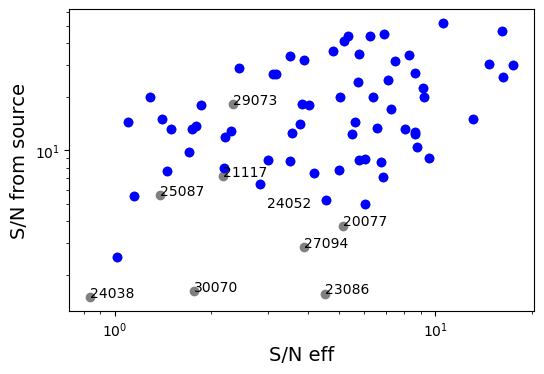

In [509]:
xx = np.linspace(0.2, 1.5, 100)
yy = 3/xx
yy1 = 1.5/xx
muse_sampling = 0.2
plt.figure(dpi = 100)
plt.scatter(isol_9["snr_eff"], isol_9["snr_from_src"], c = "gray",)
#plt.scatter(isol_snr3["snr_eff"], isol_snr3["snr_from_src"], c = "blue", \
#            label = "isolated S/N$_{\mathrm{eff}} > 3$")
plt.scatter(isol_visu["snr_eff"], isol_visu["snr_from_src"], c = "blue", \
            label = "visually ok for morpho")
#plt.scatter(isol_snr3_good_runs["radius"]/isol_snr3_good_runs["psf_fwhm"], isol_snr3_good_runs["snr_max"], c = "blue")
#plt.scatter(isol_notgood_runs["snr_eff"], isol_notgood_runs["snr_from_src"], \
#            facecolors = "none", edgecolors = "red", s = 100, label = "bad runs")
#plt.plot(xx, yy, c = "red", linestyle = "--", label = "S/N$_{\mathrm{eff}} = 3$")
#plt.plot(xx, yy1, c = "pink", linestyle = "--", label = "S/N$_{\mathrm{eff}} = 1.5$")
plt.xlabel("S/N eff", size = 14)
plt.ylabel("S/N from source", size = 14)
#plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.axhline()
#plt.legend()
#plt.xlim((0.2,8))
#plt.ylim((2,50))


X = np.array(isol_visu_nok["snr_eff"])
Y = np.array(isol_visu_nok["snr_from_src"])
txt = np.array(isol_visu_nok["ID"])

for i in range(len(isol_visu_nok)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    

Text(0, 0.5, 'sed logM*')

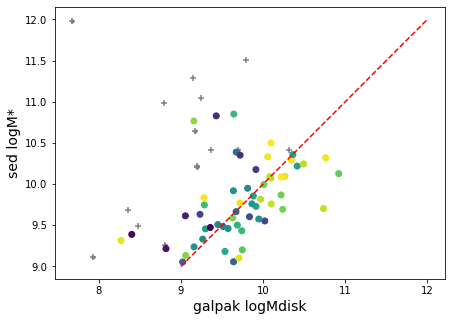

In [510]:
plt.figure(figsize = (7, 5))
plt.scatter(isol_9["log_Mdisk"], isol_9["sed_logMass"], c = "gray", marker = "+")
plt.scatter(isol_visu["log_Mdisk"], isol_visu["sed_logMass"], c = "grey", marker = ".")
plt.scatter(isol_visu_rot["log_Mdisk"], isol_visu_rot["sed_logMass"], \
            c = (isol_visu_rot["v22"]+0.01)/isol_visu_rot["velocity_dispersion_2Rd"])
plt.plot([9,12], [9,12], c = "r", linestyle = "--")
plt.xlabel("galpak logMdisk", size = 14)
plt.ylabel("sed logM*", size = 14)

**~5-10 problematic cases to investigate...**

Nb of isolated galaxies with logM>9 : 72


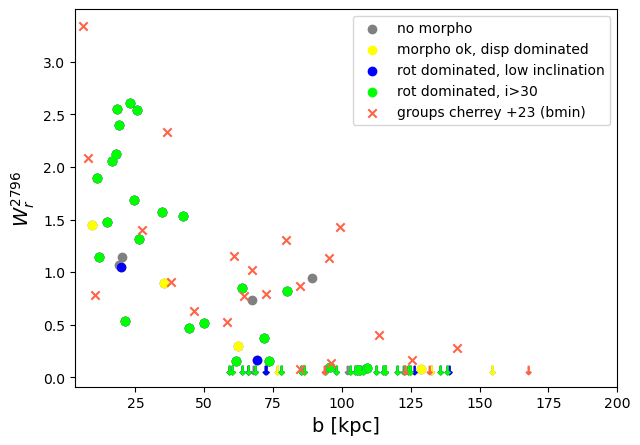

In [511]:
print("Nb of isolated galaxies with logM>9 :", len(isol_9))
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)
dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'gray',\
                 zorder = 2, label = "no morpho")
plt.scatter(isol_visu_abs["B_KPC"], isol_visu_abs["REW_2796"], c = 'yellow',\
                 zorder = 2, label = "morpho ok, disp dominated")
plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["REW_2796"], c = 'blue',\
                 zorder = 2, label = "rot dominated, low inclination")
plt.scatter(isol_incl_visu_rot_abs["B_KPC"], isol_incl_visu_rot_abs["REW_2796"], c = 'lime',\
                 zorder = 2, label = "rot dominated, i>30")

plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = "x", c = "tomato", zorder = 3, \
           label = "groups cherrey +23 (bmin)")

#plt.scatter(isol_high_alpha_abs["B_KPC"], isol_high_alpha_abs["REW_2796"], c = 'red',\
#                 label = "high alpha", zorder = 2)

#plt.scatter(isol_mid_alpha_abs["B_KPC"], isol_mid_alpha_abs["REW_2796"], c = 'lime',\
#                 label = "mid alpha", zorder = 2)

#plt.scatter(isol_low_alpha_abs["B_KPC"], isol_low_alpha_abs["REW_2796"], c = 'blue',\
#                 label = "low alpha", zorder = 2)

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "gray",\
             marker = "$\downarrow$")
plt.scatter(isol_visu_noabs["B_KPC"], isol_visu_noabs["detection_limit_p75"], c = 'yellow',\
                 zorder = 2, marker = "$\downarrow$")
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["detection_limit_p75"], c = 'blue',\
                 zorder = 2, marker = "$\downarrow$")
plt.scatter(isol_incl_visu_rot_noabs["B_KPC"], isol_incl_visu_rot_noabs["detection_limit_p75"], c = 'lime',\
                 zorder = 2, marker = "$\downarrow$")

#plt.scatter(isol_high_alpha_noabs["B_KPC"], isol_high_alpha_noabs["detection_limit_p75"], c = "red",\
#             marker = "$\downarrow$")

#plt.scatter(isol_mid_alpha_noabs["B_KPC"], isol_mid_alpha_noabs["detection_limit_p75"], c = "lime",\
#             marker = "$\downarrow$")

#plt.scatter(isol_low_alpha_noabs["B_KPC"], isol_low_alpha_noabs["detection_limit_p75"], c = "blue",\
#             marker = "$\downarrow$")

plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["REW_2796"]+0.075, marker = "$\downarrow$", c = "tomato", zorder = 3)

#plt.colorbar(label = "N2000")
plt.xlim((3, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
plt.legend()

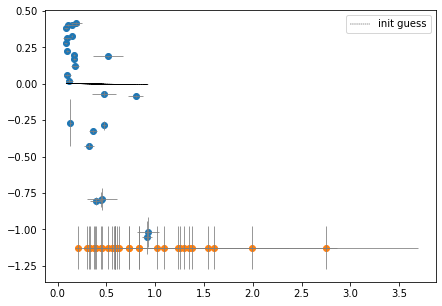

In [512]:
x1 = np.array(isol_visu_rot_abs["B_KPC"]/isol_visu_rot_abs["Rvir"])
x2 = np.array(isol_visu_rot_noabs["B_KPC"]/isol_visu_rot_noabs["Rvir"])
y1 = np.array(np.log10(isol_visu_rot_abs["REW_2796"]))
y2 = np.array(np.log10(isol_visu_rot_noabs["detection_limit_p75"]))
sig_x1 = np.array(isol_visu_rot_abs["B_KPC"]*isol_visu_rot_abs["Rvir_err"]/(isol_visu_rot_abs["Rvir"]**2))
sig_x2 = np.array(isol_visu_rot_noabs["B_KPC"]*isol_visu_rot_noabs["Rvir_err"]/(isol_visu_rot_noabs["Rvir"]**2))
sig_y1 = np.array(isol_visu_rot_abs["sig_REW_2796"]/isol_visu_rot_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

plt.figure(figsize = (7,5))
#plt.axhline(0, c = "red", linestyle = "--")
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.errorbar(x1, y1, xerr = sig_x1, yerr = sig_y1, c = "gray", linestyle = "none", linewidth = 0.8)
plt.errorbar(x2, y2, xerr = sig_x2, yerr = sig_y2, c = "gray", linestyle = "none", linewidth = 0.8)

#plt.plot(x0, A + B*x0, label = "true function", c = "black")

plt.plot(x1, 0.001 -0.008*x1, label = "init guess", c = "black", linestyle = "--", linewidth = 0.4)
plt.legend()

In [513]:
fit_bnorm = minimize(gt.logL_stats_total, np.array([0.2,-3, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_bnorm_1sig = np.diag(fit_bnorm.hess_inv)**0.5
fit_bnorm_1sig_inf = fit_bnorm['x'] - fit_bnorm_1sig
fit_bnorm_1sig_sup = fit_bnorm['x'] + fit_bnorm_1sig
fit_bnorm

      fun: 42.25938380857636
 hess_inv: array([[ 4.44522442e-02, -8.02122806e-02, -4.68060699e-05],
       [-8.02122806e-02,  2.27079003e-01, -1.54511754e-02],
       [-4.68060699e-05, -1.54511754e-02,  1.29385122e-02]])
      jac: array([ 4.76837158e-07,  0.00000000e+00, -1.43051147e-06])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 19
     njev: 21
   status: 0
  success: True
        x: array([ 0.18982305, -2.491955  ,  0.71559092])

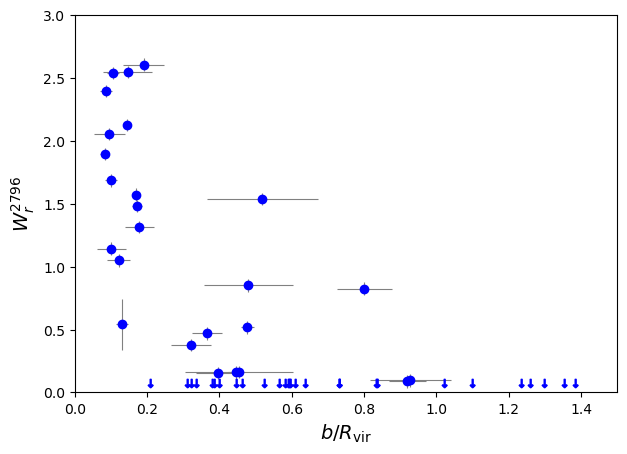

In [518]:
plt.figure(figsize = (7, 5), dpi = 100)
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

X = np.linspace(0.05, 4, 100)
#plt.plot(X, 10**gt.model(fit_bnorm['x'], X), linewidth = 1.0, c = "black", \
#         linestyle = "--", label = "best fit all")
#plt.fill_between(X, 10**gt.model(fit_bnorm_1sig_inf, X), 10**gt.model(fit_bnorm_1sig_sup, X), \
#                 color = "gray", alpha = 0.2, linewidth = 0)

plt.scatter(isol_visu_rot_abs["B_KPC"]/isol_visu_rot_abs["Rvir"], isol_visu_rot_abs["REW_2796"],\
            c = "blue",\
                 label = "isolated logM*>9", zorder = 2, vmin = -1, vmax = 1)
plt.errorbar(np.array(isol_visu_rot_abs["B_KPC"]/isol_visu_rot_abs["Rvir"]), \
            np.array(isol_visu_rot_abs["REW_2796"]),\
            xerr = np.array(isol_visu_rot_abs["B_KPC"]*isol_visu_rot_abs["Rvir_err"]/(isol_visu_rot_abs["Rvir"]**2)),\
            yerr = np.maximum(isol_visu_rot_abs["sig_REW_2796"], 0.05),\
             linestyle = "none", c = "grey", linewidth = 0.8, zorder = 1)
plt.scatter(isol_visu_rot_noabs["B_KPC"]/isol_visu_rot_noabs["Rvir"], isol_visu_rot_noabs["detection_limit_p75"],\
            c = "blue",\
             marker = "$\downarrow$", vmin = -1, vmax = 1)
#plt.colorbar(label = "$\\alpha$")

plt.xlim((0.00, 1.5))
plt.ylim((0.00, 3))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$b / R_{\mathrm{vir}}$", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
#plt.legend()

X = np.array(isol_visu_rot_abs["B_KPC"]/isol_visu_rot_abs["Rvir"])
Y = np.array(isol_visu_rot_abs["REW_2796"])
txt = np.array(isol_visu_rot_abs["ID"])

#for i in range(len(isol_visu_rot_abs)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))


(0.0, 1.5)

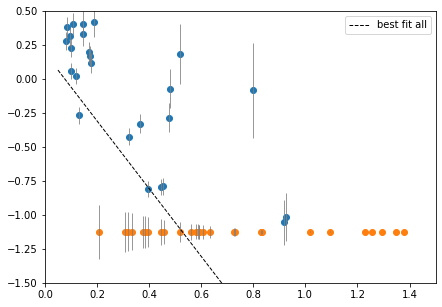

In [515]:
from scipy.stats import norm
param = fit_bnorm['x']
residuals = (param[0] + x1*param[1]) - y1
log_likelihood = norm.logpdf(residuals, scale = (sig_y1**2 + param[2]**2)**0.5)

residuals_sup = y2 - (param[0] + x2*param[1])
log_likelihood_sup = norm.logcdf(residuals_sup, scale = (sig_y2**2 + param[2]**2)**0.5)

plt.figure(figsize = (7,5))
#plt.axhline(0, c = "red", linestyle = "--")
plt.scatter(x1, y1)
plt.scatter(x2, y2)
#plt.errorbar(x1, y1, xerr = sig_x1, yerr = sig_y1, c = "gray", linestyle = "none", linewidth = 0.8)
#plt.errorbar(x2, y2, xerr = sig_x2, yerr = sig_y2, c = "gray", linestyle = "none", linewidth = 0.8)


plt.errorbar(x1, y1, yerr = log_likelihood/10, c = "gray", linestyle = "none", linewidth = 0.8)
plt.errorbar(x2, y2, yerr = log_likelihood_sup/10, c = "gray", linestyle = "none", linewidth = 0.8)

#plt.plot(x0, A + B*x0, label = "true function", c = "black")

X = np.linspace(0.05, 1, 100)
plt.plot(X, gt.model(fit_bnorm['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all")
#plt.plot(x1, 0.001 -0.008*x1, label = "init guess", c = "black", linestyle = "--", linewidth = 0.4)
plt.legend()
plt.ylim((-1.5, 0.5))
plt.xlim((0, 1.5))

main sequence

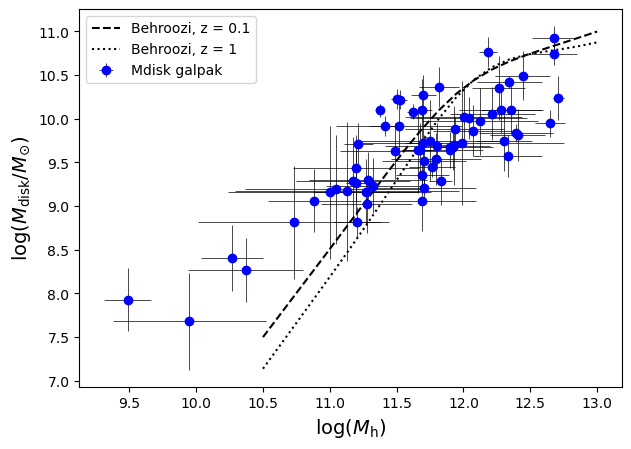

In [516]:
logMh = np.linspace(10.5,13.,20)
logMstar_1 = gt.Behroozi_2019_inv(logMh, 1)
logMstar_01 = gt.Behroozi_2019_inv(logMh, 0.1)

plt.figure(figsize = (7,5), dpi = 100)
plt.errorbar(np.array(isol_behroozi["log_Mvir"]), np.array(isol_behroozi["log_Mdisk"]),\
             xerr = np.array(isol_behroozi["log_Mvir_err"]), \
             yerr = np.array(isol_behroozi["log_Mdisk_err"]), \
             label = "Mdisk galpak", linestyle = "none", color = "blue", marker = "o", ecolor = "black", \
            linewidth = 0.5)
plt.plot(logMh, logMstar_01, c = "black", linestyle = "--", label = "Behroozi, z = 0.1")
plt.plot(logMh, logMstar_1, c = "black", linestyle = "dotted", label = "Behroozi, z = 1")
plt.legend()
plt.xlabel("$\log(M_{\mathrm{h}})$", size = 14)
plt.ylabel("$\log(M_{\mathrm{disk}}/M_{\odot})$", size = 14)

X = np.array(isol_behroozi["log_Mvir"])
Y = np.array(isol_behroozi["log_Mdisk"])
txt = np.array(isol_behroozi["ID"])

#for i in range(len(isol_behroozi)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))

# Catalog figure

In [592]:
len(isol_visu)

65

In [605]:
65/3

21.666666666666668

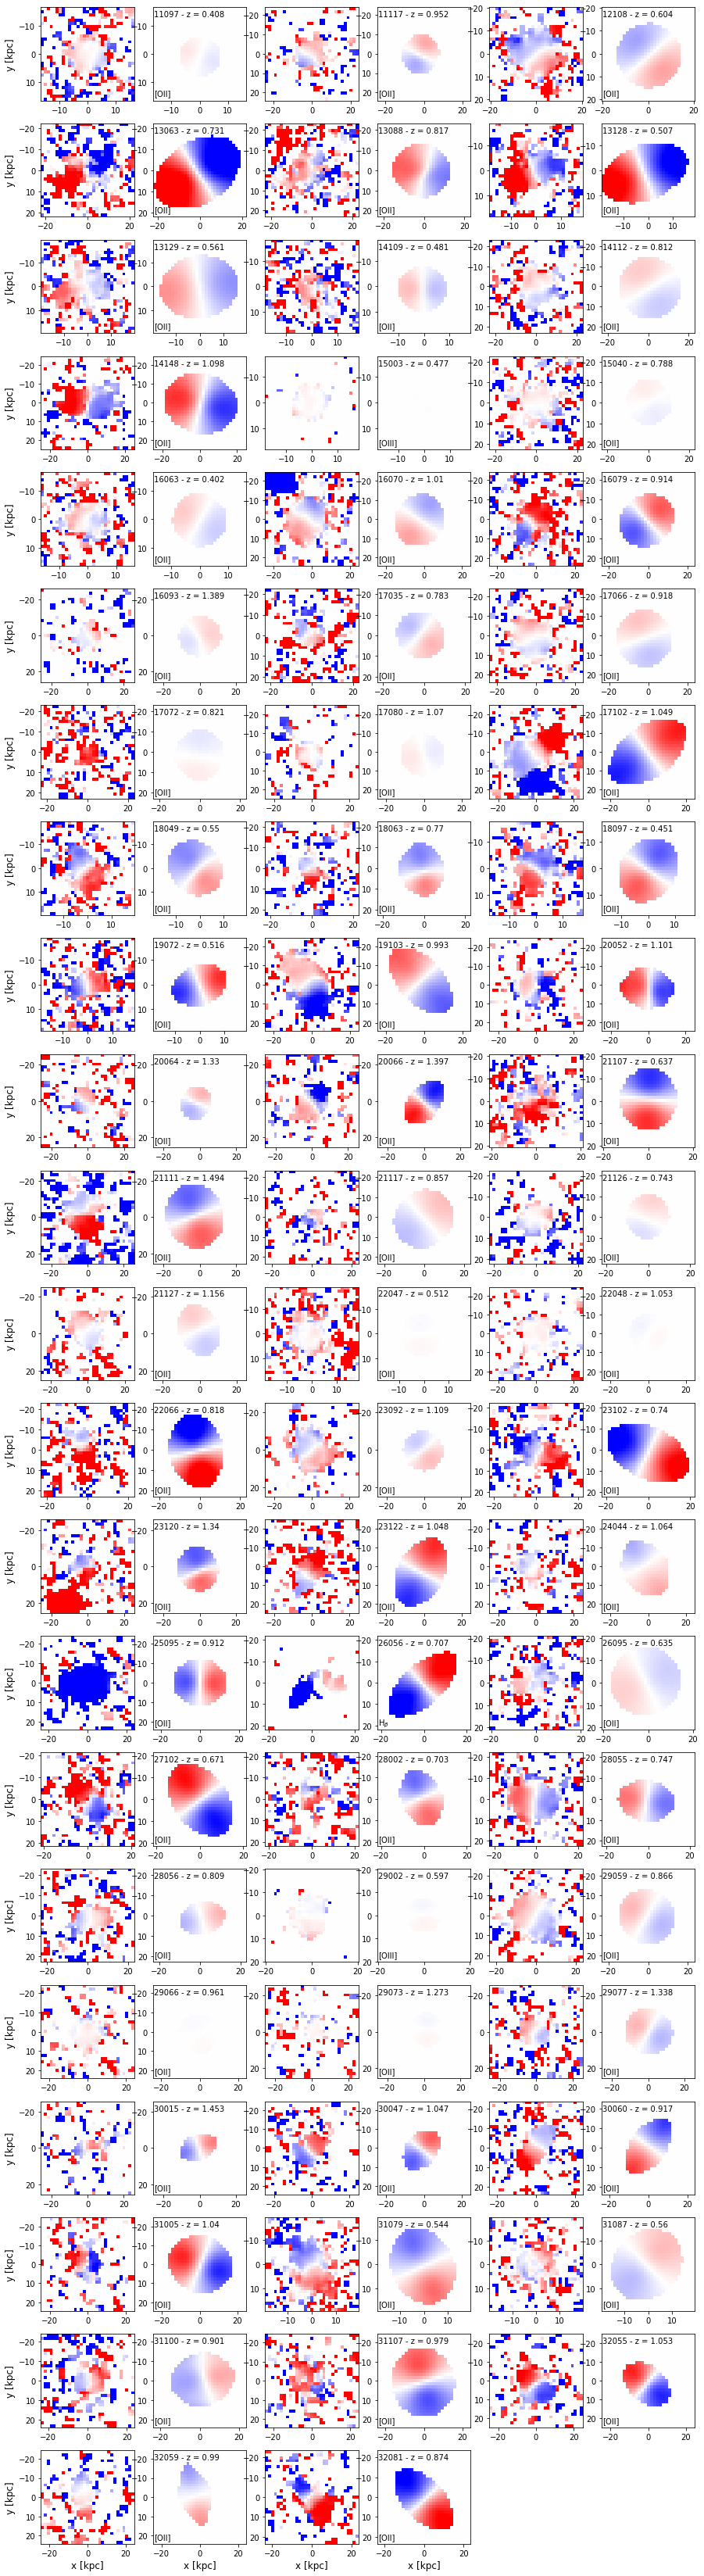

In [613]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter

input_path = "/muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/"
output_path = "/muse/MG2QSO/private/analysis/galpak_dr2/"
run_dir = output_path

lines_dict = {"HALPHA":"ha", "HBETA": "hb", "HDELTA": "hd", "HGAMMA": "hg", "OII":"o2", "OIII5007": "o3"}
k = 0

Nrows = 22
Ncols = 3

fig = plt.figure(figsize=(15, 60),constrained_layout=False)
gs = fig.add_gridspec(nrows = Nrows, ncols = Ncols*2, wspace=0.2, hspace=0.1)

for i, r in isol_visu.iterrows():
    if k < Nrows*Ncols:
        field_id = r["field_id"]
        src_id = r["ID"] 
        run_name = r["run_name"]
        #print(r["run_name"])
        try:
            line = (r["run_name"]).split("_")[1]
        except:
            line = "Nan"
        z_src = r["Z"]
        REW2796 =r["REW_2796"]
        B_KPC = r["B_KPC"]
        incl = r["inclination"]
        alpha = r["alpha"]
        radius = r["radius"]
        snr_eff = r["snr_eff"]
        primary_auto = r["primary_auto"]
        isolated_auto = r["isolated_auto"]
        logMass = r["sed_logMass"]
        #print(output_dir, run_name, src_id, field_id)
        
        txt = str(src_id)+" - z = "+str(np.round(z_src, 3)) 
        if line == "OII":
            txt_line ="[OII]"
        elif line == "OIII5007":
            txt_line = "[OIII]"
        elif line == "HBETA":
            txt_line = "H$_{\\beta}$"

        row = k//Ncols
        col = k - (k//Ncols)*Ncols
        #print(row, col)
        # Create the Axes.
        #ax_meas = fig.add_subplot(gs[2*col:2*col+1, row:row+1])
        #ax_model = fig.add_subplot(gs[2*col+1:2*col+2, row:row+1])
        #ax_meas = fig.add_subplot(gs[row:row+1, 2*col:2*col+1])
        ax_velmap = fig.add_subplot(gs[row:row+1, 2*col:2*col+1])
        ax_model = fig.add_subplot(gs[row:row+1, 2*col+1:2*col+2])
        
        if row != Nrows-1:
            #ax_velmap.set_xticklabels([])
            #ax_model.set_xticklabels([])
            pass
        else:
            ax_model.set_xlabel("x [kpc]", size = 12)
            ax_velmap.set_xlabel("x [kpc]", size = 12)
        if col != 0:
            #ax_velmap.set_yticklabels([])
            pass
        else:
            ax_velmap.set_ylabel("y [kpc]", size = 12)
        #ax_model.set_yticklabels([])
        
        
        

        if type(run_name) is str and "cont" not in run_name:
            run_path = run_dir + field_id +"/"+field_id +"_source-"+str(src_id)+"/"+str(run_name)+"/"
            src_dir = run_dir + field_id +"/"+field_id +"_source-"+str(src_id)+"/"
            src_file = src_dir + field_id +"_source-"+str(src_id)+"_"+line+"_cube_nocont.fits"
            src_origin_file = input_path+field_id+"/products/sources/"+field_id +"_source-"+str(src_id)+".fits"
            #src = Source.from_file(src_origin_file)
            hdul = fits.open(src_file)
            data = hdul[1].data
            dd = data.sum(axis = 0)
            smoothed_data = gaussian_filter(dd, sigma=1)
            #print(run_path)
            kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z_src).value/60
            extent_arcsec = np.array([-0.2*15, 0.2*15,-0.2*15, 0.2*15])
            extent_kpc = extent_arcsec*kpc_per_arcsec

            # For the measured flux:
            img_run = plt.imread(run_path + "run_images.png")
            img_measured = img_run[10:320, 140:440]

            # For the model:
            hdulist = fits.open(run_path + "run_obs_vel_map.fits")
            img_model = hdulist[0].data
            hdulist.close()

            # For the convergence:
            #img_conv = plt.imread(run_path + "run_mcmc.png")

            kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z_src).value/60
            extent_arcsec = np.array([-0.2*15, 0.2*15,-0.2*15, 0.2*15])
            extent_kpc = extent_arcsec*kpc_per_arcsec
            #ax_meas.imshow(smoothed_data, extent = extent_kpc)
            #divider = make_axes_locatable(ax_meas)
            #cax = divider.append_axes('right', size='5%', pad=0.05)
            #ax_meas.set_xlabel("x [kpc]", size = 12)
            #ax_meas.set_ylabel("y [kpc]", size = 12)
            #ax_meas.invert_yaxis()
            #ax_meas.axis("off")

            ax_model.imshow(img_model, cmap = "bwr", vmin = -150, vmax = 150, extent = extent_kpc)
            ax_model.invert_yaxis()
            #ax_model.set_xlabel("x [kpc]", size = 12)
            #ax_model.set_ylabel("y [kpc]", size = 12)
            #ax_model.axis("off")

            #ax_conv.imshow(img_conv)
            #ax_conv.axis("off")

            # For the velmap:
            #try:
            vel = "camel_"+line+"/camel_"+ str(src_id) +"_"+lines_dict[line]+"_ssmooth" +"_vel_common.fits"
            snr = "camel_"+line+"/camel_"+ str(src_id) +"_"+lines_dict[line]+"_ssmooth" +"_snr_common.fits"
            velmap_path = run_dir + field_id +"/"+field_id +"_source-"+str(src_id)+"/"+vel
            snr_path = run_dir + field_id +"/"+field_id +"_source-"+str(src_id)+"/"+snr
            hdul_vel = fits.open(velmap_path)
            hdul_snr = fits.open(snr_path)
            img_vel = hdul_vel[0].data
            img_snr = hdul_snr[0].data
            #mask_obj = src.images["MASK_OBJ"]
            #ma = mask_obj.data
            m = np.where(img_snr>4, 1, 0)

            divider = make_axes_locatable(ax_velmap)
            #cax = divider.append_axes('right', size='5%', pad=0.05)
            im = ax_velmap.imshow(img_vel*m, vmin = -150, vmax = 150, cmap = "bwr", extent = extent_kpc)
            #fig.colorbar(im, cax=cax, orientation='vertical')
            #plt.colorbar(ax_velmap, label = "Dv [km/s]")
            #ax_velmap.set_xlabel("x [kpc]", size = 12)
            #ax_velmap.set_ylabel("y [kpc]", size = 12)
            ax_velmap.invert_yaxis()

            #except:
            #    print(src_id, ": no vel. map")
                #plt.subplot(133)
            #    ax_velmap.scatter(0,0, c = "white")

            ax_model.text(0.01, 0.9, txt, fontsize=10, transform=ax_model.transAxes)
            ax_model.text(0.01, 0.05, txt_line, fontsize=10, transform=ax_model.transAxes)

        else:
            print(src_id ,": no run" , run_name, type(run_name))
            #plt.subplot(131)
            #ax_meas.scatter(0,0, c = "white")
            #ax_meas.axis("off")
    k+=1